# CONNECTION


In [2]:
from sqlalchemy import create_engine,text
from dotenv import load_dotenv
import os

# Load environment variables from .env file
load_dotenv()

# Get DB credentials from environment
db_user = os.getenv("DB_USER")
db_password = os.getenv("DB_PASSWORD")
db_host = os.getenv("DB_HOST")
db_name = os.getenv("DB_NAME")
db_port = os.getenv("DB_PORT")

# Construct the SQLAlchemy database URL
DATABASE_URL = f"postgresql://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}"

try:
    # Create SQLAlchemy engine
    engine = create_engine(DATABASE_URL, isolation_level="AUTOCOMMIT")
    connection = engine.connect()
    print("Database connection successful!")
except Exception as e:
    print("Database connection failed.")
    print(e)


Database connection successful!


# IMPORTS AND DISPLAYS

In [3]:
import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from category_encoders import TargetEncoder
from lightgbm import LGBMRegressor
import re
import holidays
import time
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
from rapidfuzz import process, fuzz
from scipy.stats import skew, kurtosis
from scipy.stats import boxcox
import requests
from datetime import datetime, timedelta
from scipy.stats import normaltest
import scipy.stats as stats
from matplotlib.dates import DateFormatter, MonthLocator
import plotly.graph_objects as go
import plotly.express as px
import ipywidgets as widgets
from IPython.display import display
from scipy.stats import mode

pd.set_option('display.width', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None) 

C:\Users\rijul\AppData\Local\Temp\ipykernel_12104\544679267.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# DATASET LOADING

In [280]:
query = """
WITH combined_sales AS (
    -- UrbanPiper Data
    SELECT
        m.brand_id,
        b.brand_name,
        m.res_id,
        r.region_id,
        r.city,
        ups.branch_name AS branch_name,
        CASE 
            WHEN LOWER(ups.customer_name) LIKE '%swiggy%' THEN 'Swiggy' 
            WHEN LOWER(ups.customer_name) LIKE '%zomato%' THEN 'Zomato' 
            ELSE 'Other' 
        END AS channel_name,
        DATE(ups.invoice_date) AS order_date,
        (ups.gross_amount + ups.other_charge_amount) AS gross_sales,
        ups.discounts AS discount_amount,
        1 AS order_count
    FROM 
        urban_piper_sales ups
    JOIN 
        master_ids m ON ups.pos_id = m.pos_id
    JOIN 
        brand b ON m.brand_id = b.brand_id
    LEFT JOIN 
        region r ON m.region_id = r.region_id
    WHERE
        ups.sale_status = 'Completed'

    UNION ALL

    -- PetPooja Data
    SELECT
        m.brand_id,
        b.brand_name,
        m.res_id,
        r.region_id,
        r.city,
        pps.restaurant_name AS branch_name,
        CASE 
            WHEN LOWER(pps.sub_order_type) LIKE '%swiggy%' THEN 'Swiggy' 
            WHEN LOWER(pps.sub_order_type) LIKE '%zomato%' THEN 'Zomato' 
            ELSE 'Other' 
        END AS channel_name,
        DATE(pps.date) AS order_date,
        (pps.my_amount + pps.delivery_charge + pps.container_charge + pps.service_charge + pps.additional_charge) AS gross_sales,
        pps.discount AS discount_amount,
        1 AS order_count
    FROM 
        order_summary_report_petpooja pps
    JOIN 
        master_ids m ON pps.pos_id = m.pos_id
    JOIN 
        brand b ON m.brand_id = b.brand_id
    LEFT JOIN 
        region r ON m.region_id = r.region_id
    WHERE
        pps.status = 'Success'

    UNION ALL

    -- Rista Data
    SELECT
        m.brand_id,
        b.brand_name,
        m.res_id,
        r.region_id,
        r.city,
        rs.branch_name AS branch_name,
        CASE 
            WHEN LOWER(rs.order_source) LIKE '%swiggy%' THEN 'Swiggy' 
            WHEN LOWER(rs.order_source) LIKE '%zomato%' THEN 'Zomato' 
            ELSE 'Other' 
        END AS channel_name,
        DATE(rs.invoice_date) AS order_date,
        (rs.gross_amount + rs.direct_charge_amount + rs.other_charge_amount + rs.tip) AS gross_sales,
        rs.discounts AS discount_amount,
        1 AS order_count
    FROM 
        sales_transaction_audit_report_rista rs
    JOIN 
        master_ids m ON rs.pos_id = m.pos_id
    JOIN 
        brand b ON m.brand_id = b.brand_id
    LEFT JOIN 
        region r ON m.region_id = r.region_id
    WHERE
        rs.sale_status = 'Closed'
)

-- Aggregate Daily Combined Data for Bercos (brand_id = 1016)
SELECT
    brand_id,
    brand_name,
    region_id,
    city,
    branch_name,
    order_date,
    
    -- Aggregated values
    SUM(gross_sales) AS total_gross_sales,
    SUM(discount_amount) AS total_discount_amount,
    SUM(order_count) AS total_order_count,

    -- Combined AOV rounded to 2 decimals
    CASE 
        WHEN SUM(order_count) > 0 THEN ROUND(SUM(gross_sales) / SUM(order_count), 2)
        ELSE 0
    END AS average_order_value
FROM 
    combined_sales
WHERE 
    brand_id = 1039
    AND channel_name IN ('Swiggy', 'Zomato') 
GROUP BY 
    brand_id, brand_name, region_id, city, branch_name, order_date
ORDER BY 
    order_date, city, branch_name;


"""
data_df = pd.read_sql(text(query), connection)
display(data_df.head())


,brand_id,brand_name,region_id,city,branch_name,order_date,total_gross_sales,total_discount_amount,total_order_count,average_order_value
0,1039,Dannys Fried Chicken,1228,Delhi,Danny's Fried Chicken (GK1),2024-01-01,18685.0,3141.87,38,491.71
1,1039,Dannys Fried Chicken,1253,Delhi,Danny's Fried Chicken(Vasant Kunj),2024-01-01,6958.0,1163.98,16,434.88
2,1039,Dannys Fried Chicken,1813,Gurgaon,Danny's Fried chicken (Sushant Lok),2024-01-01,24631.0,4567.80,49,502.67
3,1039,Dannys Fried Chicken,1326,Gurgaon,Danny's Fried Chicken(Rodeo Drive),2024-01-01,35686.0,7367.25,85,419.84
4,1039,Dannys Fried Chicken,1305,Noida,Danny's Fried Chicken(Noida sec 73),2024-01-01,6697.0,1473.60,17,393.94


In [281]:
# Group by branch_name and count unique region_ids
region_check = data_df.groupby('branch_name')['region_id'].nunique()

# Filter branch_names with more than one unique region_id
branches_with_multiple_regions = region_check[region_check > 1]

# Display the result
print("Branches with more than one region_id:")
print(branches_with_multiple_regions)


Branches with more than one region_id:
Series([], Name: region_id, dtype: int64)


In [282]:
# Get detailed region IDs for those branches
detailed_view = data_df[data_df['branch_name'].isin(branches_with_multiple_regions.index)][['city','branch_name', 'region_id']].drop_duplicates().sort_values(by='branch_name')
display(detailed_view)


,city,branch_name,region_id


# ADD DISCOUNT PERCENTAGE

In [283]:
# Avoid division by zero
data_df['discount_percentage'] = data_df.apply(
    lambda row: (row['total_discount_amount'] / row['total_gross_sales']) * 100 
    if row['total_gross_sales'] != 0 else 0, 
    axis=1
)

# Optional: Round for clarity
data_df['discount_percentage'] = data_df['discount_percentage'].round(2)

# Display updated DataFrame
display(data_df[['order_date', 'city', 'branch_name', 'total_gross_sales', 'total_discount_amount', 'discount_percentage']].head())


,order_date,city,branch_name,total_gross_sales,total_discount_amount,discount_percentage
0,2024-01-01,Delhi,Danny's Fried Chicken (GK1),18685.0,3141.87,16.81
1,2024-01-01,Delhi,Danny's Fried Chicken(Vasant Kunj),6958.0,1163.98,16.73
2,2024-01-01,Gurgaon,Danny's Fried chicken (Sushant Lok),24631.0,4567.80,18.54
3,2024-01-01,Gurgaon,Danny's Fried Chicken(Rodeo Drive),35686.0,7367.25,20.64
4,2024-01-01,Noida,Danny's Fried Chicken(Noida sec 73),6697.0,1473.60,22.00


# ADD MONTHLY STATISTICS 

In [284]:
# Ensure order_date is in datetime format
data_df['order_date'] = pd.to_datetime(data_df['order_date'])

# Add temporal features
data_df['day_of_week'] = data_df['order_date'].dt.dayofweek           # 0 = Monday, ..., 6 = Sunday
data_df['week_of_year'] = data_df['order_date'].dt.isocalendar().week
data_df['month'] = data_df['order_date'].dt.month
data_df['year'] = data_df['order_date'].dt.year
data_df['day_of_month'] = data_df['order_date'].dt.day
data_df['is_weekend'] = data_df['day_of_week'].isin([5, 6])           # Saturday (5) or Sunday (6)
data_df['quarter'] = data_df['order_date'].dt.quarter


# CHECK NO. OF BRANCH_NAMES

In [285]:
unique_branch_name = data_df['branch_name'].nunique()
print(f"Number of unique region_ids: {unique_branch_name}")


Number of unique region_ids: 11


# CHECK DUPLICATES

In [286]:
# Step 1: Group by res_id, region_id, branch_name, channel_name, and order_date and count occurrences
duplicate_group = data_df.groupby(['region_id', 'branch_name', 'order_date']).size().reset_index(name='count')

# Step 2: Filter groups where count > 1 (i.e., duplicates)
violating_combinations = duplicate_group[duplicate_group['count'] > 1]

print(f"Found {len(violating_combinations)} duplicate combinations (region_id, branch_name, date).\n")

# Step 3: Show a few duplicate group examples
display(violating_combinations.head())

# Step 4: View full duplicate rows from the original dataset
if not violating_combinations.empty:
    print("\nSample conflicting rows from data_df:")
    duplicates_detailed = data_df.merge(
        violating_combinations[['region_id', 'branch_name','order_date']],
        on=['region_id', 'branch_name','order_date'],
        how='inner'
    )

Found 0 duplicate combinations (region_id, branch_name, date).



,region_id,branch_name,order_date,count


# ADD HOLIDAYS

In [287]:
# Define India holidays
indian_holidays = holidays.India()

# Create a holiday flag
data_df['is_holiday'] = data_df['order_date'].isin(indian_holidays)

# Ensure order_date is datetime
data_df['order_date'] = pd.to_datetime(data_df['order_date'], errors='coerce')

# Extract unique years from the data (drop NaT)
unique_years = data_df['order_date'].dropna().dt.year.unique().astype(int).tolist()

# Generate holidays for the extracted years
indian_holidays = holidays.India(years=unique_years)

# Convert to a DataFrame for better display
holiday_df = pd.DataFrame(indian_holidays.items(), columns=["date", "holiday_name"])
holiday_df['date'] = pd.to_datetime(holiday_df['date'], errors='coerce')


display(holiday_df)
data_df['is_holiday'] = data_df['order_date'].isin(holiday_df['date'])
display(data_df.head())


,date,holiday_name
0,2024-01-26,Republic Day
1,2024-08-15,Independence Day
2,2024-10-02,Gandhi Jayanti
3,2024-05-23,Buddha Purnima
4,2024-11-01,Diwali
5,2024-08-26,Janmashtami
6,2024-10-12,Dussehra
7,2024-04-21,Mahavir Jayanti
8,2024-03-08,Maha Shivaratri
9,2024-11-15,Guru Nanak Jayanti


,brand_id,brand_name,region_id,city,branch_name,order_date,total_gross_sales,total_discount_amount,total_order_count,average_order_value,discount_percentage,day_of_week,week_of_year,month,year,day_of_month,is_weekend,quarter,is_holiday
0,1039,Dannys Fried Chicken,1228,Delhi,Danny's Fried Chicken (GK1),2024-01-01,18685.0,3141.87,38,491.71,16.81,0,1,1,2024,1,False,1,False
1,1039,Dannys Fried Chicken,1253,Delhi,Danny's Fried Chicken(Vasant Kunj),2024-01-01,6958.0,1163.98,16,434.88,16.73,0,1,1,2024,1,False,1,False
2,1039,Dannys Fried Chicken,1813,Gurgaon,Danny's Fried chicken (Sushant Lok),2024-01-01,24631.0,4567.80,49,502.67,18.54,0,1,1,2024,1,False,1,False
3,1039,Dannys Fried Chicken,1326,Gurgaon,Danny's Fried Chicken(Rodeo Drive),2024-01-01,35686.0,7367.25,85,419.84,20.64,0,1,1,2024,1,False,1,False
4,1039,Dannys Fried Chicken,1305,Noida,Danny's Fried Chicken(Noida sec 73),2024-01-01,6697.0,1473.60,17,393.94,22.00,0,1,1,2024,1,False,1,False


In [288]:
holiday_count = data_df[data_df['is_holiday'] == True].shape[0]
display(f"Number of holidays: {holiday_count}")


'Number of holidays: 170'

# CHECK WEEKEND/WEEKDAY

In [289]:
# Ensure order_date is in datetime format
data_df['order_date'] = pd.to_datetime(data_df['order_date'], errors='coerce')

# Create a column for day of the week (0 = Monday, 6 = Sunday)
data_df['day_of_week'] = data_df['order_date'].dt.dayofweek

# Create a column to indicate weekend (Saturday and Sunday)
data_df['is_weekend'] = data_df['day_of_week'].isin([5, 6])  # 5 = Saturday, 6 = Sunday

# Calculate number of weekend and weekday rows
weekend_count = data_df[data_df['is_weekend']].shape[0]
weekday_count = data_df[~data_df['is_weekend']].shape[0]

print(f"Number of weekend rows: {weekend_count}")
print(f"Number of weekday rows: {weekday_count}")

# Create a column indicating "Weekend" or "Weekday" directly without keeping extra columns
data_df['day_type'] = data_df['order_date'].dt.dayofweek.apply(lambda x: 'Weekend' if x in [5, 6] else 'Weekday')

display(data_df.head())


Number of weekend rows: 1144
Number of weekday rows: 2859


,brand_id,brand_name,region_id,city,branch_name,order_date,total_gross_sales,total_discount_amount,total_order_count,average_order_value,discount_percentage,day_of_week,week_of_year,month,year,day_of_month,is_weekend,quarter,is_holiday,day_type
0,1039,Dannys Fried Chicken,1228,Delhi,Danny's Fried Chicken (GK1),2024-01-01,18685.0,3141.87,38,491.71,16.81,0,1,1,2024,1,False,1,False,Weekday
1,1039,Dannys Fried Chicken,1253,Delhi,Danny's Fried Chicken(Vasant Kunj),2024-01-01,6958.0,1163.98,16,434.88,16.73,0,1,1,2024,1,False,1,False,Weekday
2,1039,Dannys Fried Chicken,1813,Gurgaon,Danny's Fried chicken (Sushant Lok),2024-01-01,24631.0,4567.80,49,502.67,18.54,0,1,1,2024,1,False,1,False,Weekday
3,1039,Dannys Fried Chicken,1326,Gurgaon,Danny's Fried Chicken(Rodeo Drive),2024-01-01,35686.0,7367.25,85,419.84,20.64,0,1,1,2024,1,False,1,False,Weekday
4,1039,Dannys Fried Chicken,1305,Noida,Danny's Fried Chicken(Noida sec 73),2024-01-01,6697.0,1473.60,17,393.94,22.00,0,1,1,2024,1,False,1,False,Weekday


# ADD SEASON

In [290]:
# Define a function to get the season based on the month
def get_season(month):
    if month in [12, 1, 2]:
        return "Winter"
    elif month in [3, 4]:
        return "Spring"
    elif month in [5, 6]:
        return "Summer"
    elif month in [7, 8]:
        return "Monsoon"
    else:
        return "Autumn"

# Add a season column to sales_df
data_df['season'] = data_df['order_date'].dt.month.apply(get_season)

# Display the first few rows to verify
display(data_df[['order_date', 'season']].head())

display(data_df.head())


,order_date,season
0,2024-01-01,Winter
1,2024-01-01,Winter
2,2024-01-01,Winter
3,2024-01-01,Winter
4,2024-01-01,Winter


,brand_id,brand_name,region_id,city,branch_name,order_date,total_gross_sales,total_discount_amount,total_order_count,average_order_value,discount_percentage,day_of_week,week_of_year,month,year,day_of_month,is_weekend,quarter,is_holiday,day_type,season
0,1039,Dannys Fried Chicken,1228,Delhi,Danny's Fried Chicken (GK1),2024-01-01,18685.0,3141.87,38,491.71,16.81,0,1,1,2024,1,False,1,False,Weekday,Winter
1,1039,Dannys Fried Chicken,1253,Delhi,Danny's Fried Chicken(Vasant Kunj),2024-01-01,6958.0,1163.98,16,434.88,16.73,0,1,1,2024,1,False,1,False,Weekday,Winter
2,1039,Dannys Fried Chicken,1813,Gurgaon,Danny's Fried chicken (Sushant Lok),2024-01-01,24631.0,4567.80,49,502.67,18.54,0,1,1,2024,1,False,1,False,Weekday,Winter
3,1039,Dannys Fried Chicken,1326,Gurgaon,Danny's Fried Chicken(Rodeo Drive),2024-01-01,35686.0,7367.25,85,419.84,20.64,0,1,1,2024,1,False,1,False,Weekday,Winter
4,1039,Dannys Fried Chicken,1305,Noida,Danny's Fried Chicken(Noida sec 73),2024-01-01,6697.0,1473.60,17,393.94,22.00,0,1,1,2024,1,False,1,False,Weekday,Winter


# GEOCODING

In [291]:
# -----------------------------
# Step 1: Load and Clean City-Subzone-Region Data
# -----------------------------
query = """SELECT region_id, subzone, city FROM region"""
c_df = pd.read_sql(query, connection)

# Standardize city and subzone names
c_df['city'] = c_df['city'].str.strip().str.title()
c_df['subzone'] = c_df['subzone'].str.strip().str.title()

# Remove rows where city or subzone is null or empty
c_df = c_df.dropna(subset=['city', 'subzone'])
c_df = c_df[(c_df['city'] != '') & (c_df['subzone'] != '')]

# Drop duplicate (region_id, city, subzone) triplets
c_df = c_df.drop_duplicates(subset=['region_id', 'city', 'subzone'])

# Create the final DataFrame with city, subzone, and region_id
city_df = c_df[['region_id','city', 'subzone']].sort_values(['city', 'subzone']).reset_index(drop=True)

display(city_df.head())


,region_id,city,subzone
0,2,Agra,Agra
1,759,Agra,Bbk Agra Tier-2
2,870,Agra,Civil Lines
3,1387,Agra,Civil Lines
4,672,Agra,Lohamandi


In [292]:
# -----------------------------
# Step 1: Normalize city and subzone
# -----------------------------
def normalize_subzone(text):
    return text.lower().replace('-', ' ').strip()

city_df['city'] = city_df['city'].str.lower().str.strip()
city_df['subzone'] = city_df['subzone'].apply(normalize_subzone)

# -----------------------------
# Step 2: Check for existing cache
# -----------------------------
cache_path = r'C:/Users/rijul/Desktop/geocoded_city_file.csv'

if os.path.exists(cache_path):
    print("Loading cached geocoded coordinates from file...")
    city_df = pd.read_csv(cache_path)
else:
    print("Geocoding in progress...")
    geolocator = Nominatim(user_agent="zone-intelligence")

    def geocode_with_fallback(location, fallback_location=None, retries=3):
        for _ in range(retries):
            try:
                result = geolocator.geocode(location, timeout=10)
                if not result and fallback_location:
                    result = geolocator.geocode(fallback_location, timeout=10)
                return result
            except GeocoderTimedOut:
                time.sleep(2)
        return None

    latitudes = []
    longitudes = []

    for subzone, city in zip(city_df['subzone'], city_df['city']):
        full_location = f"{subzone}, {city}, India"
        fallback_location = f"{city}, India"
        result = geocode_with_fallback(full_location, fallback_location)

        if result:
            latitudes.append(result.latitude)
            longitudes.append(result.longitude)
        else:
            latitudes.append(None)
            longitudes.append(None)

        time.sleep(1)  # Respect rate limits

    # Step 3: Attach Coordinates
    city_df['latitude'] = latitudes
    city_df['longitude'] = longitudes

    # Step 4: Drop duplicates (keeping region_id)
    city_df = city_df.drop_duplicates(subset=['region_id', 'city', 'subzone', 'latitude', 'longitude']).reset_index(drop=True)

    # Step 5: Optional - Restore title case
    city_df['city'] = city_df['city'].str.title()
    city_df['subzone'] = city_df['subzone'].str.title()

    # Step 6: Show missing geocodes
    missing = city_df[city_df['latitude'].isna()]
    if not missing.empty:
        print("\nFailed to geocode the following entries:")
        print(missing[['region_id', 'city', 'subzone']])

    # Step 7: Save the geocoded result
    city_df.to_csv(cache_path, index=False)
    print(f"\nGeocoding completed and saved to {cache_path}")

# Final output
print("\nGeocoding Completed:\n")
display(city_df[['region_id', 'city', 'subzone', 'latitude', 'longitude']].head())


Loading cached geocoded coordinates from file...

Geocoding Completed:



,region_id,city,subzone,latitude,longitude
0,2,Agra,Agra,27.175255,78.009816
1,759,Agra,Bbk Agra Tier 2,27.175255,78.009816
2,870,Agra,Civil Lines,27.199435,78.005901
3,1387,Agra,Civil Lines,27.199435,78.005901
4,672,Agra,Lohamandi,27.189606,77.994904


CHECK FOR MISSING

In [293]:
# Show rows with missing coordinates
missing_geocodes = city_df[city_df['latitude'].isna() | city_df['longitude'].isna()]

# Display the relevant columns
display(missing_geocodes[['region_id', 'city', 'subzone']])
# Step 1: Identify rows with missing coordinates
missing_geocodes = city_df[city_df['latitude'].isna() | city_df['longitude'].isna()]

# Step 2: Display missing entries (if any)
if missing_geocodes.empty:
    print("No missing geocodes in city_df.")
else:
    print("Missing geocodes found. These will be geocoded now:")
    display(missing_geocodes[['region_id', 'city', 'subzone']].head())


    city_df.update(missing_geocodes)

# Step 3: Proceed with merging after fixing geocodes
city_df_renamed = city_df.rename(columns={'subzone': 'subzone_city_df'})

merged_df = data_df.merge(
    city_df_renamed[['region_id', 'subzone_city_df', 'latitude', 'longitude']],
    on='region_id',
    how='left'
)

display(merged_df.head())


,region_id,city,subzone


No missing geocodes in city_df.


,brand_id,brand_name,region_id,city,branch_name,order_date,total_gross_sales,total_discount_amount,total_order_count,average_order_value,discount_percentage,day_of_week,week_of_year,month,year,day_of_month,is_weekend,quarter,is_holiday,day_type,season,subzone_city_df,latitude,longitude
0,1039,Dannys Fried Chicken,1228,Delhi,Danny's Fried Chicken (GK1),2024-01-01,18685.0,3141.87,38,491.71,16.81,0,1,1,2024,1,False,1,False,Weekday,Winter,Greater Kailash 1 (Gk 1),28.555850,77.243834
1,1039,Dannys Fried Chicken,1253,Delhi,Danny's Fried Chicken(Vasant Kunj),2024-01-01,6958.0,1163.98,16,434.88,16.73,0,1,1,2024,1,False,1,False,Weekday,Winter,Vasant Kunj,28.529249,77.154134
2,1039,Dannys Fried Chicken,1813,Gurgaon,Danny's Fried chicken (Sushant Lok),2024-01-01,24631.0,4567.80,49,502.67,18.54,0,1,1,2024,1,False,1,False,Weekday,Winter,Sushant Lok,28.470663,77.079813
3,1039,Dannys Fried Chicken,1326,Gurgaon,Danny's Fried Chicken(Rodeo Drive),2024-01-01,35686.0,7367.25,85,419.84,20.64,0,1,1,2024,1,False,1,False,Weekday,Winter,South City 2,28.459739,77.061209
4,1039,Dannys Fried Chicken,1305,Noida,Danny's Fried Chicken(Noida sec 73),2024-01-01,6697.0,1473.60,17,393.94,22.00,0,1,1,2024,1,False,1,False,Weekday,Winter,Sector 75,28.570633,77.327215


# ADD WEATHER

In [294]:
# Get unique locations + date ranges
unique_locations = merged_df.groupby(['latitude', 'longitude'])['order_date'].agg(['min', 'max']).reset_index()
# Weather code to description mapping
weathercode_mapping = {
    0: 'Clear', 1: 'Mainly clear', 2: 'Partly cloudy', 3: 'Overcast',
    45: 'Fog', 48: 'Depositing rime fog',
    51: 'Light drizzle', 53: 'Moderate drizzle', 55: 'Dense drizzle',
    56: 'Light freezing drizzle', 57: 'Dense freezing drizzle',
    61: 'Slight rain', 63: 'Moderate rain', 65: 'Heavy rain',
    66: 'Light freezing rain', 67: 'Heavy freezing rain',
    71: 'Slight snow fall', 73: 'Moderate snow fall', 75: 'Heavy snow fall',
    77: 'Snow grains',
    80: 'Slight rain showers', 81: 'Moderate rain showers', 82: 'Violent rain showers',
    85: 'Slight snow showers', 86: 'Heavy snow showers',
    95: 'Thunderstorm', 96: 'Thunderstorm with hail', 99: 'Thunderstorm with heavy hail'
}

def fetch_weather(lat, lon, start_date, end_date, retries=3):
    today = pd.Timestamp(datetime.utcnow().date())
    weather_records = []

    # Use archive API only for dates strictly before today
    if start_date < today:
        archive_end = min(end_date, today - pd.Timedelta(days=1))  # up to yesterday
        if archive_end >= start_date:
            weather_records.extend(fetch_from_api(
                url='https://archive-api.open-meteo.com/v1/archive',
                lat=lat, lon=lon, start=start_date, end=archive_end, retries=retries
            ))

    # Use forecast API for today and future dates only
    if end_date >= today:
        forecast_start = max(start_date, today)
        weather_records.extend(fetch_from_api(
            url='https://api.open-meteo.com/v1/forecast',
            lat=lat, lon=lon, start=forecast_start, end=end_date, retries=retries
        ))

    return weather_records


def fetch_from_api(url, lat, lon, start, end, retries=3):
    params = {
        'latitude': lat,
        'longitude': lon,
        'start_date': start.strftime('%Y-%m-%d'),
        'end_date': end.strftime('%Y-%m-%d'),
        'daily': 'temperature_2m_max,temperature_2m_min,precipitation_sum,relative_humidity_2m_max,relative_humidity_2m_min,weathercode',
        'timezone': 'auto'
    }

    attempt = 0
    while attempt < retries:
        try:
            response = requests.get(url, params=params, timeout=15)
            response.raise_for_status()
            data = response.json()
            return parse_weather_data(data, lat, lon)
        except requests.exceptions.RequestException as e:
            print(f"Attempt {attempt+1} failed for ({lat}, {lon}): {e}")
            time.sleep(2 ** attempt)
            attempt += 1
    return []


def parse_weather_data(data, lat, lon):
    weather_records = []
    daily = data.get('daily', {})
    dates = daily.get('time', [])

    for i, date in enumerate(dates):
        t_max = daily.get('temperature_2m_max', [None])[i]
        t_min = daily.get('temperature_2m_min', [None])[i]
        h_max = daily.get('relative_humidity_2m_max', [None])[i]
        h_min = daily.get('relative_humidity_2m_min', [None])[i]
        prec = daily.get('precipitation_sum', [None])[i]
        w_code = daily.get('weathercode', [None])[i]
        w_desc = weathercode_mapping.get(w_code, 'Unknown') if w_code is not None else None

        avg_temp = (t_max + t_min) / 2 if t_max is not None and t_min is not None else None
        avg_humidity = (h_max + h_min) / 2 if h_max is not None and h_min is not None else None

        weather_records.append({
            'latitude': lat,
            'longitude': lon,
            'date': pd.to_datetime(date),
            'temperature_avg': avg_temp,
            'humidity_avg': avg_humidity,
            'precipitation_sum': prec,
            'weathercode': w_code,
            'weather_condition': w_desc,
        })

    return weather_records


In [295]:
# Example of usage over your unique locations DataFrame `unique_locations`
all_weather_records = []

for idx, row in unique_locations.iterrows():
    lat, lon = row['latitude'], row['longitude']
    start_date, end_date = row['min'], row['max']
    print(f"Fetching weather for ({lat}, {lon}) from {start_date.date()} to {end_date.date()}")

    records = fetch_weather(lat, lon, start_date, end_date)
    all_weather_records.extend(records)

    time.sleep(1)  # throttle API calls

weather_df = pd.DataFrame(all_weather_records)
display(weather_df.head())

Fetching weather for (28.403652, 76.9531428) from 2025-02-05 to 2025-05-10
Fetching weather for (28.4597391, 77.0612091) from 2024-01-01 to 2025-06-30
Fetching weather for (28.4640865, 77.0836441) from 2024-12-16 to 2025-06-30
Fetching weather for (28.4706634, 77.0798127) from 2024-01-01 to 2025-04-01
Fetching weather for (28.5292495, 77.1541335) from 2024-01-01 to 2025-06-30
Fetching weather for (28.5558502, 77.2438337) from 2024-01-01 to 2025-06-30
Fetching weather for (28.5706333, 77.3272147) from 2024-01-01 to 2025-06-30
Fetching weather for (28.6035543, 77.2899208) from 2024-05-08 to 2025-06-30
Fetching weather for (28.6158874, 77.0224342) from 2024-08-13 to 2025-04-14
Fetching weather for (28.6957192, 77.175505) from 2024-05-04 to 2025-06-30


,latitude,longitude,date,temperature_avg,humidity_avg,precipitation_sum,weathercode,weather_condition
0,28.403652,76.953143,2025-02-05,14.90,71.0,1.0,55,Dense drizzle
1,28.403652,76.953143,2025-02-06,14.55,62.0,0.0,2,Partly cloudy
2,28.403652,76.953143,2025-02-07,14.15,61.0,0.0,3,Overcast
3,28.403652,76.953143,2025-02-08,15.35,65.5,0.0,3,Overcast
4,28.403652,76.953143,2025-02-09,15.00,71.0,0.0,3,Overcast


In [296]:
 
# Ensure order_date is datetime
merged_df['order_date'] = pd.to_datetime(merged_df['order_date'])
weather_df['date'] = pd.to_datetime(weather_df['date'])

# Merge weather data into final_df
data_final_df = merged_df.merge(
    weather_df,
    how='left',
    left_on=['latitude', 'longitude', 'order_date'],
    right_on=['latitude', 'longitude', 'date']
)

# Optional: drop the duplicate 'date' column from weather_df
data_final_df.drop(columns=['date'], inplace=True)

display(data_final_df.head())

,brand_id,brand_name,region_id,city,branch_name,order_date,total_gross_sales,total_discount_amount,total_order_count,average_order_value,discount_percentage,day_of_week,week_of_year,month,year,day_of_month,is_weekend,quarter,is_holiday,day_type,season,subzone_city_df,latitude,longitude,temperature_avg,humidity_avg,precipitation_sum,weathercode,weather_condition
0,1039,Dannys Fried Chicken,1228,Delhi,Danny's Fried Chicken (GK1),2024-01-01,18685.0,3141.87,38,491.71,16.81,0,1,1,2024,1,False,1,False,Weekday,Winter,Greater Kailash 1 (Gk 1),28.555850,77.243834,11.25,80.0,0.0,3,Overcast
1,1039,Dannys Fried Chicken,1253,Delhi,Danny's Fried Chicken(Vasant Kunj),2024-01-01,6958.0,1163.98,16,434.88,16.73,0,1,1,2024,1,False,1,False,Weekday,Winter,Vasant Kunj,28.529249,77.154134,11.20,80.5,0.0,3,Overcast
2,1039,Dannys Fried Chicken,1813,Gurgaon,Danny's Fried chicken (Sushant Lok),2024-01-01,24631.0,4567.80,49,502.67,18.54,0,1,1,2024,1,False,1,False,Weekday,Winter,Sushant Lok,28.470663,77.079813,11.25,82.5,0.0,3,Overcast
3,1039,Dannys Fried Chicken,1326,Gurgaon,Danny's Fried Chicken(Rodeo Drive),2024-01-01,35686.0,7367.25,85,419.84,20.64,0,1,1,2024,1,False,1,False,Weekday,Winter,South City 2,28.459739,77.061209,10.70,83.5,0.0,3,Overcast
4,1039,Dannys Fried Chicken,1305,Noida,Danny's Fried Chicken(Noida sec 73),2024-01-01,6697.0,1473.60,17,393.94,22.00,0,1,1,2024,1,False,1,False,Weekday,Winter,Sector 75,28.570633,77.327215,11.30,80.0,0.0,3,Overcast


In [297]:
data_final_df.shape

(4003, 29)

CHECK FOR DUPLICATES

In [298]:
# Step 1: Count number of rows per branch_name and order_date
dup_counts = (
    data_final_df.groupby(['branch_name', 'order_date'])
    .size()
    .reset_index(name='row_count')
)

# Step 2: Filter for duplicates (row_count > 1)
duplicates = dup_counts[dup_counts['row_count'] > 1]

# Step 3: Merge back to original data to see full rows for those duplicates
duplicate_rows = data_final_df.merge(duplicates, on=['branch_name', 'order_date'], how='inner')

print(f"Number of duplicated (branch_name, order_date) pairs: {len(duplicates)}")
# Step 4: Display duplicate rows sorted by branch_name and order_date
duplicate_rows_sorted = duplicate_rows.sort_values(by=['branch_name', 'order_date'])

display(duplicate_rows_sorted[['region_id','branch_name', 'order_date'] + 
                              [col for col in duplicate_rows_sorted.columns if col not in ['region_id','branch_name', 'order_date', 'row_count']]].head())


Number of duplicated (branch_name, order_date) pairs: 0


,region_id,branch_name,order_date,brand_id,brand_name,city,total_gross_sales,total_discount_amount,total_order_count,average_order_value,discount_percentage,day_of_week,week_of_year,month,year,day_of_month,is_weekend,quarter,is_holiday,day_type,season,subzone_city_df,latitude,longitude,temperature_avg,humidity_avg,precipitation_sum,weathercode,weather_condition


DROP REGION ID

In [299]:
data_final_df = data_final_df.drop(columns=['region_id'])

MERGE DUPLICATES

In [300]:
# Define aggregation logic
agg_funcs = {
    'brand_id': 'first',
    'brand_name': 'first',
    'city': 'first',
    'total_gross_sales': 'sum',
    'total_discount_amount': 'sum',
    'total_order_count': 'sum',
    'average_order_value': 'mean',  # placeholder, will recompute below
    'discount_percentage': 'mean',  # placeholder, will recompute below
    'day_of_week': 'first',
    'week_of_year': 'first',
    'month': 'first',
    'year': 'first',
    'day_of_month': 'first',
    'quarter': 'first',
    'is_holiday': 'first',
    'day_type': 'first',
    'season': 'first',
    'subzone_city_df': lambda x: ', '.join(sorted(set(map(str, x.dropna())))),
    'latitude': 'mean',
    'longitude': 'mean',
    'temperature_avg': 'mean',
    'humidity_avg': 'mean',
    'precipitation_sum': 'sum',
    'weathercode': 'first',
    'weather_condition': 'first'
}

# Step 1: Group and aggregate
grouped_df = data_final_df.groupby(['branch_name', 'order_date'], as_index=False).agg(agg_funcs)

# Step 2: Recompute accurate metrics
grouped_df['average_order_value'] = (
    grouped_df['total_gross_sales'] / grouped_df['total_order_count']
).round(2)

grouped_df['discount_percentage'] = (
    grouped_df['total_discount_amount'] / grouped_df['total_gross_sales'] * 100
).round(2)

# Step 3: Find combinations that had duplicates in the original df
dup_counts = data_final_df.groupby(['branch_name', 'order_date']).size().reset_index(name='count')
duplicates_only_keys = dup_counts[dup_counts['count'] > 1][['branch_name', 'order_date']]

# Step 4: Filter grouped_df to only keep merged duplicates
merged_duplicates_only = pd.merge(grouped_df, duplicates_only_keys, on=['branch_name', 'order_date'], how='inner')

# Step 5: Display only merged duplicate rows
display(merged_duplicates_only.shape)
display(merged_duplicates_only.head())


(0, 27)

,branch_name,order_date,brand_id,brand_name,city,total_gross_sales,total_discount_amount,total_order_count,average_order_value,discount_percentage,day_of_week,week_of_year,month,year,day_of_month,quarter,is_holiday,day_type,season,subzone_city_df,latitude,longitude,temperature_avg,humidity_avg,precipitation_sum,weathercode,weather_condition


REMOVE DUPLICATES

In [301]:
# Remove rows that are part of duplicated (branch_name, order_date) pairs
data_final_df_cleaned = data_final_df.merge(
    duplicates[['branch_name', 'order_date']],
    on=['branch_name', 'order_date'],
    how='left',
    indicator=True
).query('_merge == "left_only"').drop(columns=['_merge'])

# Display result
print(f"Rows after removing duplicates: {len(data_final_df_cleaned)}")
display(data_final_df_cleaned.head())


Rows after removing duplicates: 4003


,brand_id,brand_name,city,branch_name,order_date,total_gross_sales,total_discount_amount,total_order_count,average_order_value,discount_percentage,day_of_week,week_of_year,month,year,day_of_month,is_weekend,quarter,is_holiday,day_type,season,subzone_city_df,latitude,longitude,temperature_avg,humidity_avg,precipitation_sum,weathercode,weather_condition
0,1039,Dannys Fried Chicken,Delhi,Danny's Fried Chicken (GK1),2024-01-01,18685.0,3141.87,38,491.71,16.81,0,1,1,2024,1,False,1,False,Weekday,Winter,Greater Kailash 1 (Gk 1),28.555850,77.243834,11.25,80.0,0.0,3,Overcast
1,1039,Dannys Fried Chicken,Delhi,Danny's Fried Chicken(Vasant Kunj),2024-01-01,6958.0,1163.98,16,434.88,16.73,0,1,1,2024,1,False,1,False,Weekday,Winter,Vasant Kunj,28.529249,77.154134,11.20,80.5,0.0,3,Overcast
2,1039,Dannys Fried Chicken,Gurgaon,Danny's Fried chicken (Sushant Lok),2024-01-01,24631.0,4567.80,49,502.67,18.54,0,1,1,2024,1,False,1,False,Weekday,Winter,Sushant Lok,28.470663,77.079813,11.25,82.5,0.0,3,Overcast
3,1039,Dannys Fried Chicken,Gurgaon,Danny's Fried Chicken(Rodeo Drive),2024-01-01,35686.0,7367.25,85,419.84,20.64,0,1,1,2024,1,False,1,False,Weekday,Winter,South City 2,28.459739,77.061209,10.70,83.5,0.0,3,Overcast
4,1039,Dannys Fried Chicken,Noida,Danny's Fried Chicken(Noida sec 73),2024-01-01,6697.0,1473.60,17,393.94,22.00,0,1,1,2024,1,False,1,False,Weekday,Winter,Sector 75,28.570633,77.327215,11.30,80.0,0.0,3,Overcast


MERGE IN DF

In [302]:
# Combine cleaned unique rows with merged duplicate rows
data_final_df_cleaned = pd.concat([data_final_df_cleaned, merged_duplicates_only], ignore_index=True)

# Optional: Sort for cleanliness
data_final_df_cleaned = data_final_df_cleaned.sort_values(by=['branch_name', 'order_date']).reset_index(drop=True)

# Confirmation
print(f"Final shape of data_final_df_cleaned: {data_final_df_cleaned.shape}")
display(data_final_df_cleaned.head())


Final shape of data_final_df_cleaned: (4003, 28)


,brand_id,brand_name,city,branch_name,order_date,total_gross_sales,total_discount_amount,total_order_count,average_order_value,discount_percentage,day_of_week,week_of_year,month,year,day_of_month,is_weekend,quarter,is_holiday,day_type,season,subzone_city_df,latitude,longitude,temperature_avg,humidity_avg,precipitation_sum,weathercode,weather_condition
0,1039,Dannys Fried Chicken,Gurgaon,DANNY'S FRIED CHICKEN(Galleria Market),2024-12-16,2400.00,0.00,4,600.00,0.00,0,51,12,2024,16,False,4,False,Weekday,Winter,Dlf Phase 4,28.464087,77.083644,12.85,68.5,0.0,0,Clear
1,1039,Dannys Fried Chicken,Gurgaon,DANNY'S FRIED CHICKEN(Galleria Market),2024-12-17,1028.00,0.00,2,514.00,0.00,1,51,12,2024,17,False,4,False,Weekday,Winter,Dlf Phase 4,28.464087,77.083644,14.30,71.5,0.0,3,Overcast
2,1039,Dannys Fried Chicken,Gurgaon,DANNY'S FRIED CHICKEN(Galleria Market),2024-12-18,1688.67,99.99,4,422.17,5.92,2,51,12,2024,18,False,4,False,Weekday,Winter,Dlf Phase 4,28.464087,77.083644,13.45,70.5,0.0,3,Overcast
3,1039,Dannys Fried Chicken,Gurgaon,DANNY'S FRIED CHICKEN(Galleria Market),2024-12-19,5391.00,574.97,11,490.09,10.67,3,51,12,2024,19,False,4,False,Weekday,Winter,Dlf Phase 4,28.464087,77.083644,13.85,64.5,0.0,0,Clear
4,1039,Dannys Fried Chicken,Gurgaon,DANNY'S FRIED CHICKEN(Galleria Market),2024-12-20,3679.00,599.58,6,613.17,16.30,4,51,12,2024,20,False,4,False,Weekday,Winter,Dlf Phase 4,28.464087,77.083644,16.00,61.5,0.0,0,Clear


CHECK FOR DUPLICATES

In [303]:
# Check for duplicates after cleaning
remaining_duplicates = (
    data_final_df_cleaned
    .groupby(['branch_name', 'order_date'])
    .size()
    .reset_index(name='row_count')
    .query('row_count > 1')
)

# Display remaining duplicates if any
print(remaining_duplicates)


Empty DataFrame
Columns: [branch_name, order_date, row_count]
Index: []


In [304]:
# Check for exact match of branch_name and order_date
check_row = data_final_df_cleaned[
    (data_final_df_cleaned['branch_name'] == 'Burgrill Vadodara') &
    (data_final_df_cleaned['order_date'] == pd.to_datetime('2025-04-10'))
]

# Display result
if not check_row.empty:
    print("Found data for 'Burgrill Vadodara' on 2025-04-10:")
    display(check_row)
else:
    print("No data found for 'Burgrill Vadodara' on 2025-04-10.")


No data found for 'Burgrill Vadodara' on 2025-04-10.


# DATA CLEANING

In [305]:
data_final_df_cleaned = data_final_df_cleaned.drop(columns=['subzone_city_df','weathercode','latitude','longitude'], errors='ignore')
data_final_df_cleaned.shape

# 1. Remove Leading/Trailing Spaces
str_cols = data_final_df_cleaned.select_dtypes(include='object').columns
for col in str_cols:
    data_final_df_cleaned[col] = data_final_df_cleaned[col].astype(str).str.strip()
    
missing_counts = data_final_df_cleaned.isna().sum()
print("Missing values per column:\n")
print(missing_counts)

# Identify categorical columns
categorical_cols = data_final_df_cleaned.select_dtypes(include=['object', 'category']).columns

# Count and fill missing values
for col in categorical_cols:
    missing_count = data_final_df[col].isna().sum()
    if missing_count > 0:
        print(f"Found {missing_count} missing values in '{col}'. Filling with 'Unknown'.")
        data_final_df[col] = data_final_df[col].fillna('Unknown')

# Identify numerical columns
numerical_cols = data_final_df_cleaned.select_dtypes(include=['number']).columns

# Fill missing values with 0
data_final_df_cleaned[numerical_cols] = data_final_df_cleaned[numerical_cols].fillna(0)

# Ensure no negative values
for col in numerical_cols:
    data_final_df_cleaned[col] = data_final_df_cleaned[col].apply(lambda x: max(0, x))

# Convert to datetime and coerce errors
data_final_df_cleaned['order_date'] = pd.to_datetime(data_final_df_cleaned['order_date'], errors='coerce')

# Count and print missing or invalid dates
nat_count = data_final_df_cleaned['order_date'].isna().sum()
print(f"\nFound {nat_count} rows with missing or invalid 'order_date'. Removing them...")

# Drop rows with invalid dates
data_final_df_cleaned = data_final_df_cleaned.dropna(subset=['order_date']).reset_index(drop=True)

# 5. Count and Remove Duplicates
duplicate_count = data_final_df_cleaned.duplicated().sum()
print(f"\nFound {duplicate_count} duplicate rows. Removing them...")
data_final_df_cleaned = data_final_df_cleaned.drop_duplicates().reset_index(drop=True)

# Step 1: Define invalid outlet mask
invalid_mask = data_final_df_cleaned['branch_name'].isna() | data_final_df_cleaned['branch_name'].str.strip().str.lower().isin(['', '-', 'na', 'none'])

# Step 2: Show rows with invalid outlets before removal
invalid_branch_name_rows = data_final_df_cleaned[invalid_mask]
print(f"Found {invalid_mask.sum()} rows with invalid branch name. Removing them...\n")
print("Rows with invalid branch name:\n")
print(invalid_branch_name_rows)

# Step 3: Remove rows with invalid outlets
data_final_df_cleaned = data_final_df_cleaned[~invalid_mask].copy()

data_final_df_cleaned['brand_id'] = data_final_df_cleaned['brand_id'].astype(int)

# 6. Text Cleaning Function (City, Outlet, Brand)
def clean_text(text):
    if pd.isna(text):
        return 'unknown'
    text = text.lower().strip()                # Lowercase and strip
    text = re.sub(r'\s+', ' ', text)           # Remove extra spaces
    text = re.sub(r'[^\w\s]', '', text)        # Remove punctuation
    return text

text_cols = ['city', 'branch_name', 'brand_name']
for col in text_cols:
    data_final_df_cleaned[col] = data_final_df_cleaned[col].apply(clean_text)


data_final_df_cleaned.isnull().sum()

# Fill weather columns: numeric with 0, condition with 'Unknown'
weather_cols = ['temperature_avg', 'humidity_avg', 'precipitation_sum','weather_condition']

for col in weather_cols:
    if col in data_final_df_cleaned.columns:
        if col == 'weather_condition':
            data_final_df_cleaned[col] = data_final_df_cleaned[col].fillna('Unknown')
        else:
            data_final_df_cleaned[col] = data_final_df_cleaned[col].fillna(0)

# 9. Capitalize for Readability

data_final_df_cleaned['city'] = data_final_df_cleaned['city'].str.title()
data_final_df_cleaned['branch_name'] = data_final_df_cleaned['branch_name'].str.title()
data_final_df_cleaned['brand_name'] = data_final_df_cleaned['brand_name'].str.title()

# 10. Reorder Columns for Clarity

cols = [
    'brand_id', 'brand_name','city', 'branch_name', 
    'order_date', 'total_gross_sales', 'discount_percentage','total_order_count',
    'average_order_value','is_holiday','day_type','season','day_of_week','week_of_year','month',
    'year','day_of_month','is_weekend','quarter','temperature_avg','humidity_avg',
    'precipitation_sum','weather_condition'
]
data_final_df_cleaned = data_final_df_cleaned[cols]

print("\n Data Cleaning Completed. Sample Data:\n")
display(data_final_df_cleaned.head())


Missing values per column:

brand_id                 0
brand_name               0
city                     0
branch_name              0
order_date               0
total_gross_sales        0
total_discount_amount    0
total_order_count        0
average_order_value      0
discount_percentage      0
day_of_week              0
week_of_year             0
month                    0
year                     0
day_of_month             0
is_weekend               0
quarter                  0
is_holiday               0
day_type                 0
season                   0
temperature_avg          0
humidity_avg             0
precipitation_sum        7
weather_condition        0
dtype: int64

Found 0 rows with missing or invalid 'order_date'. Removing them...

Found 0 duplicate rows. Removing them...
Found 0 rows with invalid branch name. Removing them...

Rows with invalid branch name:

Empty DataFrame
Columns: [brand_id, brand_name, city, branch_name, order_date, total_gross_sales, total_discoun

,brand_id,brand_name,city,branch_name,order_date,total_gross_sales,discount_percentage,total_order_count,average_order_value,is_holiday,day_type,season,day_of_week,week_of_year,month,year,day_of_month,is_weekend,quarter,temperature_avg,humidity_avg,precipitation_sum,weather_condition
0,1039,Dannys Fried Chicken,Gurgaon,Dannys Fried Chickengalleria Market,2024-12-16,2400.00,0.00,4,600.00,False,Weekday,Winter,0,51,12,2024,16,False,4,12.85,68.5,0.0,Clear
1,1039,Dannys Fried Chicken,Gurgaon,Dannys Fried Chickengalleria Market,2024-12-17,1028.00,0.00,2,514.00,False,Weekday,Winter,1,51,12,2024,17,False,4,14.30,71.5,0.0,Overcast
2,1039,Dannys Fried Chicken,Gurgaon,Dannys Fried Chickengalleria Market,2024-12-18,1688.67,5.92,4,422.17,False,Weekday,Winter,2,51,12,2024,18,False,4,13.45,70.5,0.0,Overcast
3,1039,Dannys Fried Chicken,Gurgaon,Dannys Fried Chickengalleria Market,2024-12-19,5391.00,10.67,11,490.09,False,Weekday,Winter,3,51,12,2024,19,False,4,13.85,64.5,0.0,Clear
4,1039,Dannys Fried Chicken,Gurgaon,Dannys Fried Chickengalleria Market,2024-12-20,3679.00,16.30,6,613.17,False,Weekday,Winter,4,51,12,2024,20,False,4,16.00,61.5,0.0,Clear


# EDA

In [306]:

# Count rows and columns
rows, columns = data_final_df_cleaned.shape

print(f"Total Rows: {rows}")
print(f"Total Columns: {columns}")


Total Rows: 4003
Total Columns: 23


In [307]:

cat_cols=data_final_df_cleaned.select_dtypes(include=['object']).columns
num_cols = data_final_df_cleaned.select_dtypes(include=np.number).columns.tolist()
print("Categorical Variables:")
print(cat_cols)
print("Numerical Variables:")
print(num_cols)


Categorical Variables:
Index(['brand_name', 'city', 'branch_name', 'day_type', 'season', 'is_weekend',
       'weather_condition'],
      dtype='object')
Numerical Variables:
['brand_id', 'total_gross_sales', 'discount_percentage', 'total_order_count', 'average_order_value', 'day_of_week', 'week_of_year', 'month', 'year', 'day_of_month', 'quarter', 'temperature_avg', 'humidity_avg', 'precipitation_sum']


In [308]:
data_final_df_cleaned.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4003 entries, 0 to 4002
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   brand_id             4003 non-null   int32         
 1   brand_name           4003 non-null   object        
 2   city                 4003 non-null   object        
 3   branch_name          4003 non-null   object        
 4   order_date           4003 non-null   datetime64[ns]
 5   total_gross_sales    4003 non-null   float64       
 6   discount_percentage  4003 non-null   float64       
 7   total_order_count    4003 non-null   int64         
 8   average_order_value  4003 non-null   float64       
 9   is_holiday           4003 non-null   bool          
 10  day_type             4003 non-null   object        
 11  season               4003 non-null   object        
 12  day_of_week          4003 non-null   int64         
 13  week_of_year         4003 non-nul

In [309]:
# Check for duplicate rows
duplicate_rows = data_final_df_cleaned[data_final_df_cleaned.duplicated()]

# Print number of duplicates
print(f"Number of duplicate rows: {duplicate_rows.shape[0]}")


Number of duplicate rows: 0


In [310]:

# Optionally display a few duplicate rows
if not duplicate_rows.empty:
    display(duplicate_rows.head())
else:
    print("No duplicate rows found.")


No duplicate rows found.


In [311]:
# Count missing (null) values in each column
missing_values = data_final_df_cleaned.isnull().sum()

# Display the results
print("Missing values per column:")
print(missing_values[missing_values > 0])  # Only show columns with missing values

Missing values per column:
Series([], dtype: int64)


In [312]:
print(data_final_df_cleaned.columns)

Index(['brand_id', 'brand_name', 'city', 'branch_name', 'order_date',
       'total_gross_sales', 'discount_percentage', 'total_order_count',
       'average_order_value', 'is_holiday', 'day_type', 'season',
       'day_of_week', 'week_of_year', 'month', 'year', 'day_of_month',
       'is_weekend', 'quarter', 'temperature_avg', 'humidity_avg',
       'precipitation_sum', 'weather_condition'],
      dtype='object')


In [313]:
data_final_df_cleaned.describe()


,brand_id,order_date,total_gross_sales,discount_percentage,total_order_count,average_order_value,day_of_week,week_of_year,month,year,day_of_month,quarter,temperature_avg,humidity_avg,precipitation_sum
count,4003.0,4003,4003.000000,4003.000000,4003.000000,4003.000000,4003.000000,4003.000000,4003.000000,4003.000000,4003.000000,4003.000000,4003.000000,4003.000000,4003.000000
mean,1039.0,2024-10-26 00:37:46.300274688,30138.616987,23.572293,64.080190,468.982908,2.997752,22.843118,5.678491,2024.388708,15.733950,2.219335,24.950387,58.614039,2.429553
min,1039.0,2024-01-01 00:00:00,239.000000,0.000000,1.000000,227.000000,0.000000,1.000000,1.000000,2024.000000,1.000000,1.000000,9.650000,11.000000,0.000000
25%,1039.0,2024-06-30 00:00:00,17162.500000,18.915000,37.000000,410.970000,1.000000,10.000000,3.000000,2024.000000,8.000000,1.000000,18.800000,45.500000,0.000000
50%,1039.0,2024-11-08 00:00:00,27723.000000,21.730000,61.000000,450.730000,3.000000,21.000000,5.000000,2024.000000,16.000000,2.000000,26.700000,61.000000,0.000000
75%,1039.0,2025-03-01 00:00:00,38890.340000,26.260000,86.000000,507.420000,5.000000,35.000000,8.000000,2025.000000,23.000000,3.000000,30.100000,76.000000,0.400000
max,1039.0,2025-06-30 00:00:00,134670.370000,50.960000,233.000000,1508.000000,6.000000,52.000000,12.000000,2025.000000,31.000000,4.000000,39.850000,92.000000,280.400000
std,0.0,NaN,18934.602143,7.931184,36.434422,88.513137,2.001310,14.740547,3.395665,0.487518,8.775358,1.098068,7.184204,19.662725,10.962080


In [314]:
print(data_final_df_cleaned.nunique())


brand_id                  1
brand_name                1
city                      3
branch_name              10
order_date              547
total_gross_sales      3963
discount_percentage    1950
total_order_count       194
average_order_value    3662
is_holiday                2
day_type                  2
season                    5
day_of_week               7
week_of_year             52
month                    12
year                      2
day_of_month             31
is_weekend                2
quarter                   4
temperature_avg         802
humidity_avg            163
precipitation_sum       241
weather_condition        10
dtype: int64


In [315]:
# Find rows with at least one null value
null_rows = data_final_df_cleaned[data_final_df_cleaned.isnull().any(axis=1)]

# Count of such rows
print(f"Rows with at least one null value: {null_rows.shape[0]}")


Rows with at least one null value: 0


In [316]:

# Optionally, display a few of them
if not null_rows.empty:
    display(null_rows.head())
else:
    print("All rows are complete — no missing values across any columns.")


All rows are complete — no missing values across any columns.


In [317]:
print(data_final_df_cleaned.dtypes)


brand_id                        int32
brand_name                     object
city                           object
branch_name                    object
order_date             datetime64[ns]
total_gross_sales             float64
discount_percentage           float64
total_order_count               int64
average_order_value           float64
is_holiday                       bool
day_type                       object
season                         object
day_of_week                     int64
week_of_year                    int64
month                           int64
year                            int64
day_of_month                    int64
is_weekend                     object
quarter                         int64
temperature_avg               float64
humidity_avg                  float64
precipitation_sum             float64
weather_condition              object
dtype: object


brand_id
Skew : 0.0


C:\Users\rijul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


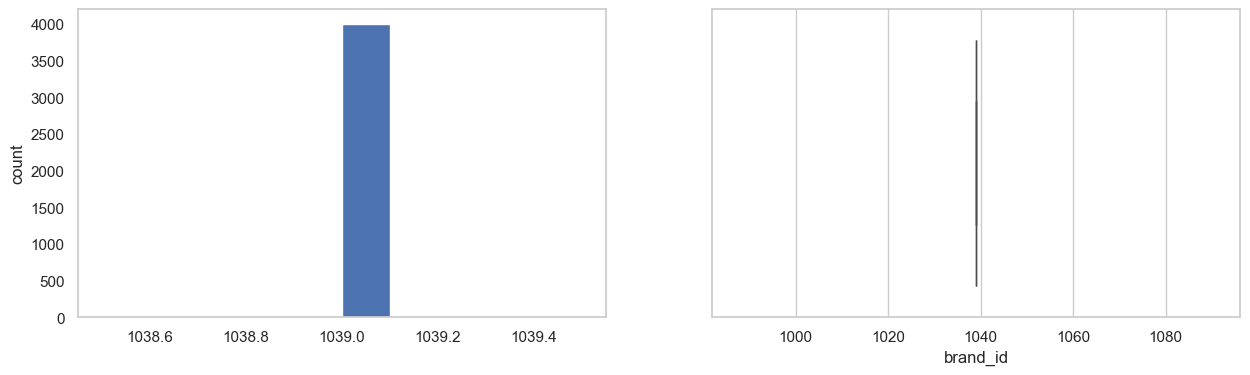

total_gross_sales
Skew : 1.26


C:\Users\rijul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


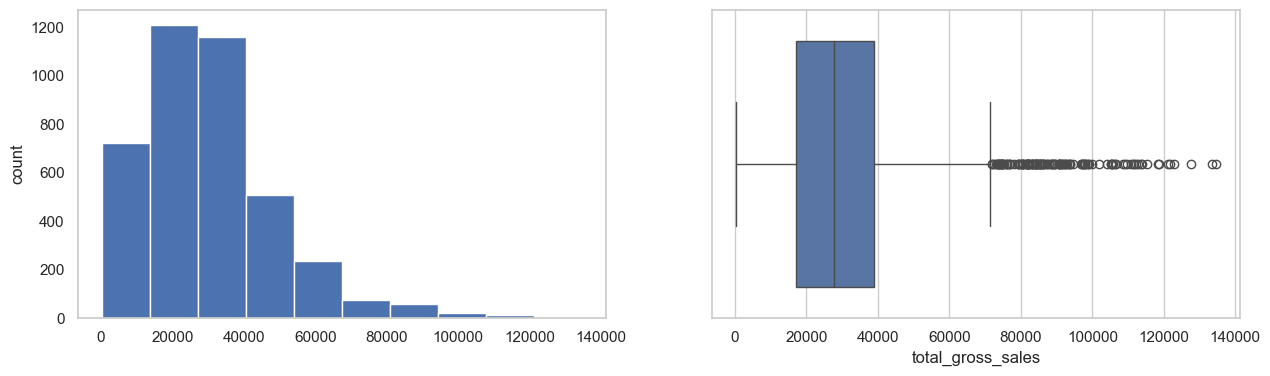

discount_percentage
Skew : 0.67


C:\Users\rijul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


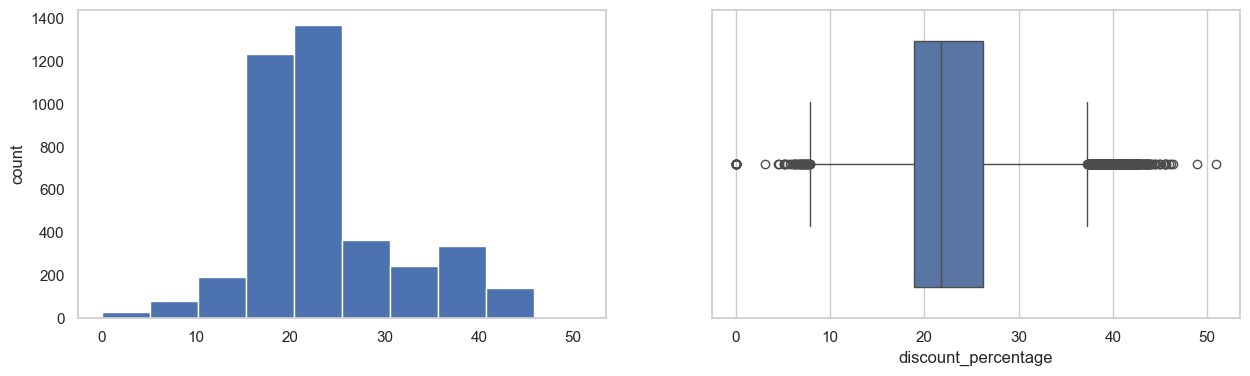

total_order_count
Skew : 0.66


C:\Users\rijul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


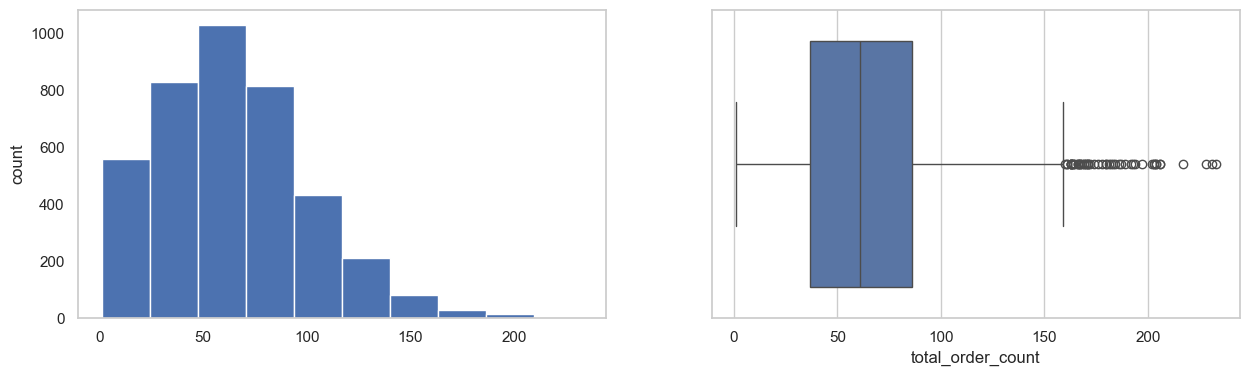

average_order_value
Skew : 1.74


C:\Users\rijul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


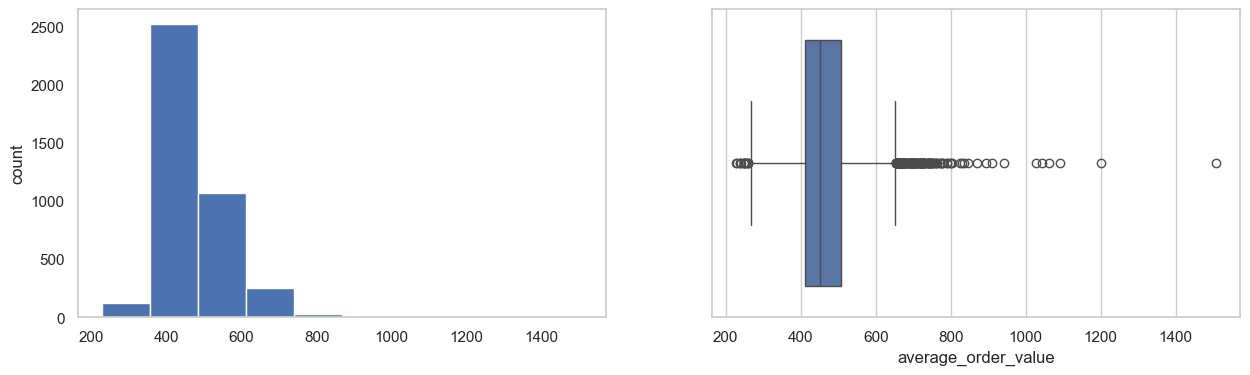

day_of_week
Skew : -0.0


C:\Users\rijul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


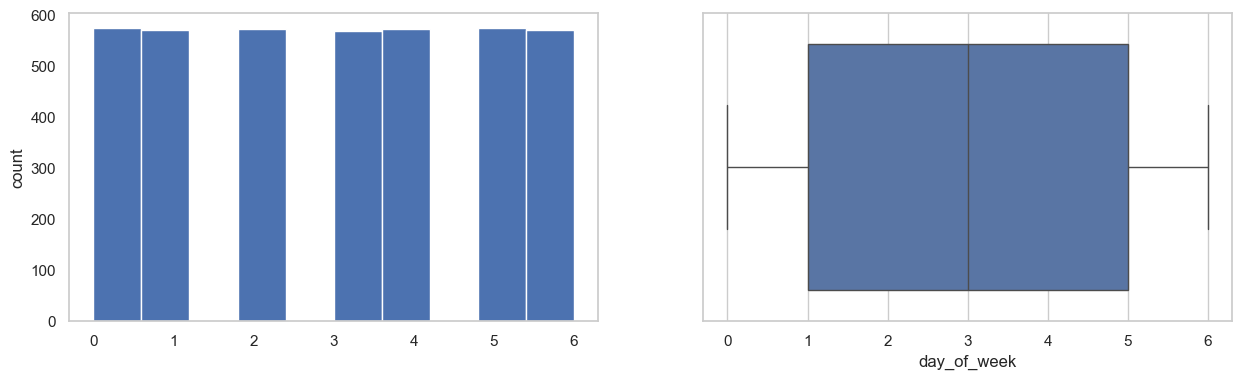

week_of_year
Skew : 0.38


C:\Users\rijul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


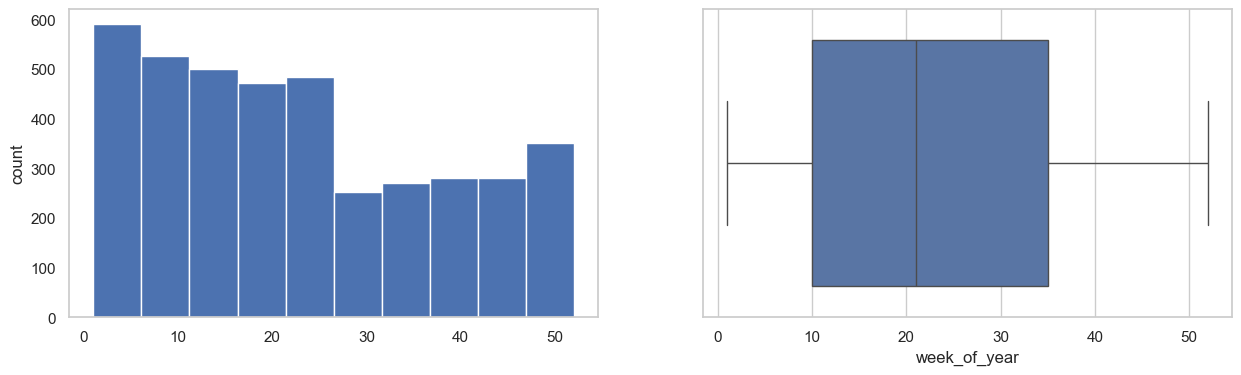

month
Skew : 0.38


C:\Users\rijul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


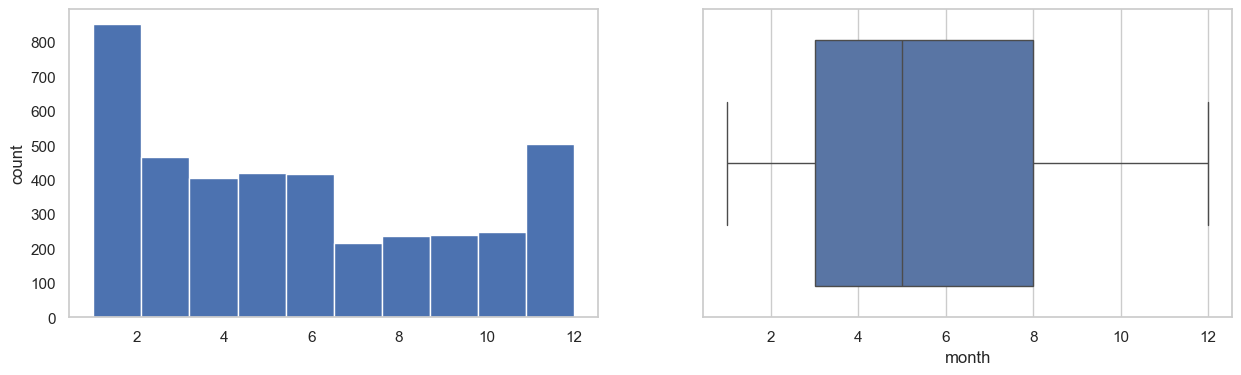

year
Skew : 0.46


C:\Users\rijul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


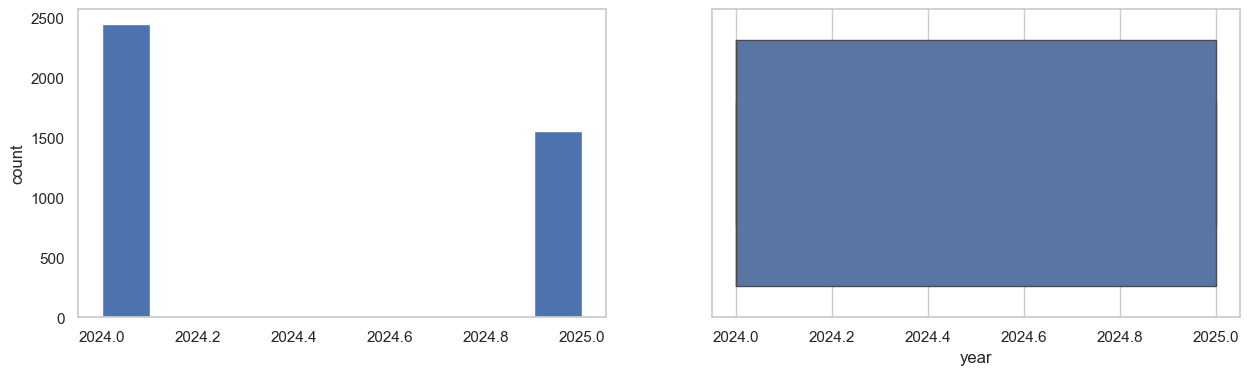

day_of_month
Skew : 0.0


C:\Users\rijul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


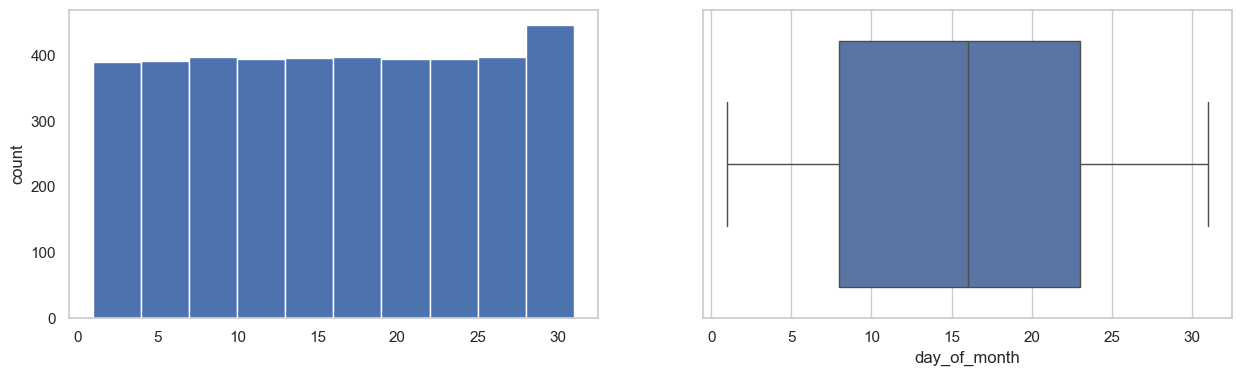

quarter
Skew : 0.41


C:\Users\rijul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


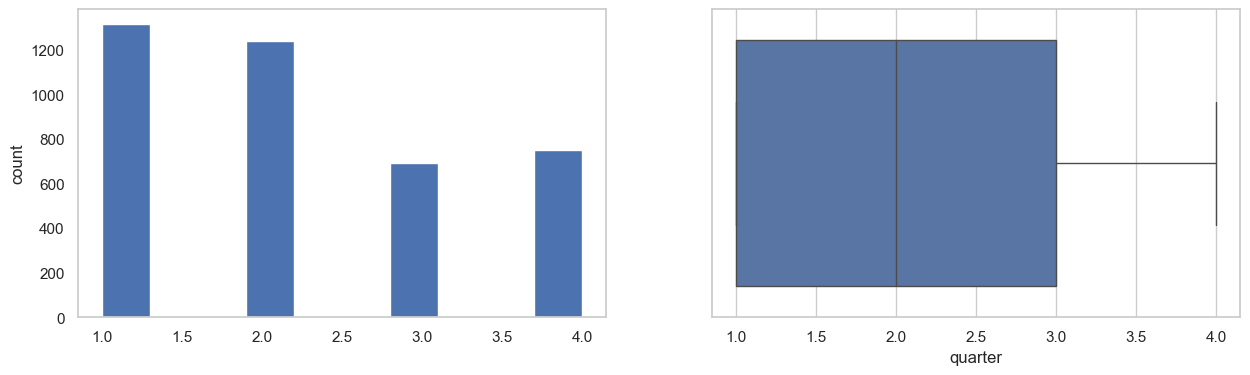

temperature_avg
Skew : -0.28


C:\Users\rijul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


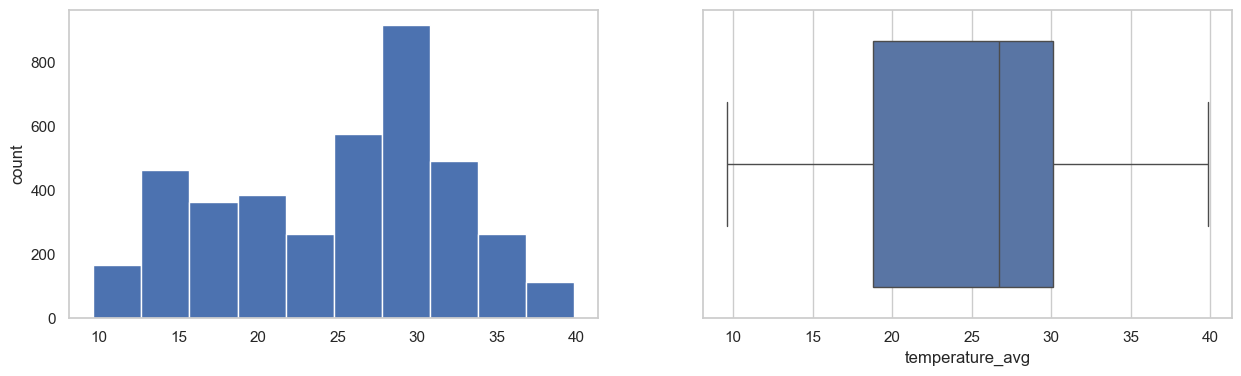

humidity_avg
Skew : -0.47


C:\Users\rijul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


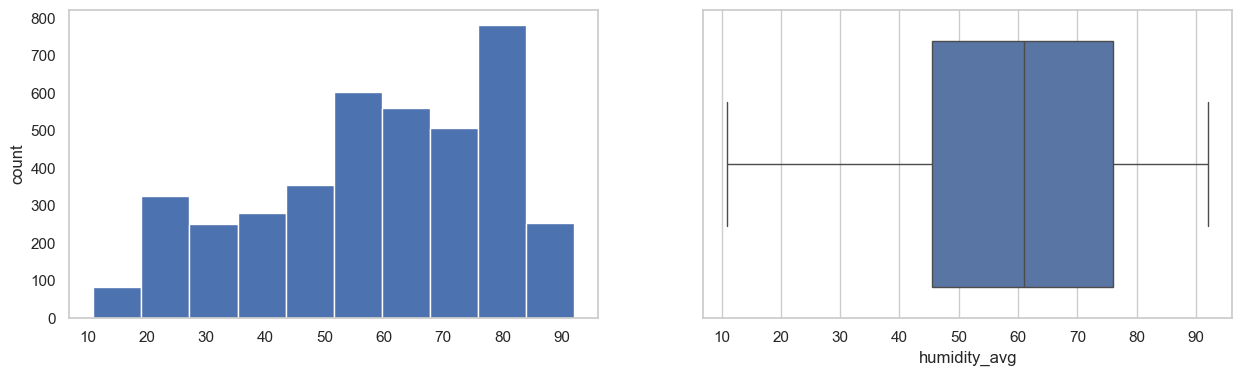

precipitation_sum
Skew : 15.27


C:\Users\rijul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


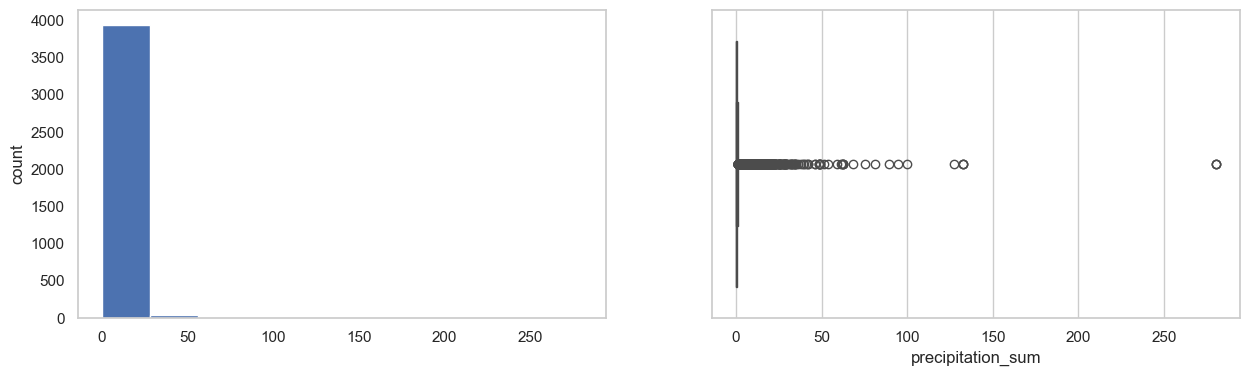

brand_id
Skew : 0.0


C:\Users\rijul\AppData\Local\Temp\ipykernel_12104\2749468202.py:17: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data_final_df_cleaned[col], shade=True)
C:\Users\rijul\AppData\Local\Temp\ipykernel_12104\2749468202.py:17: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data_final_df_cleaned[col], shade=True)


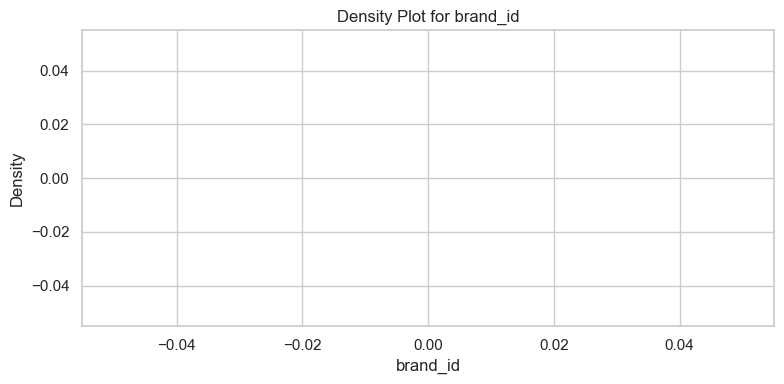

total_gross_sales
Skew : 1.26


C:\Users\rijul\AppData\Local\Temp\ipykernel_12104\2749468202.py:17: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data_final_df_cleaned[col], shade=True)


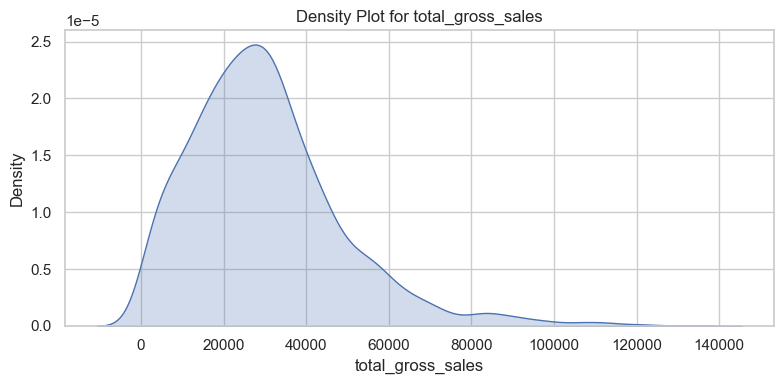

discount_percentage
Skew : 0.67


C:\Users\rijul\AppData\Local\Temp\ipykernel_12104\2749468202.py:17: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data_final_df_cleaned[col], shade=True)


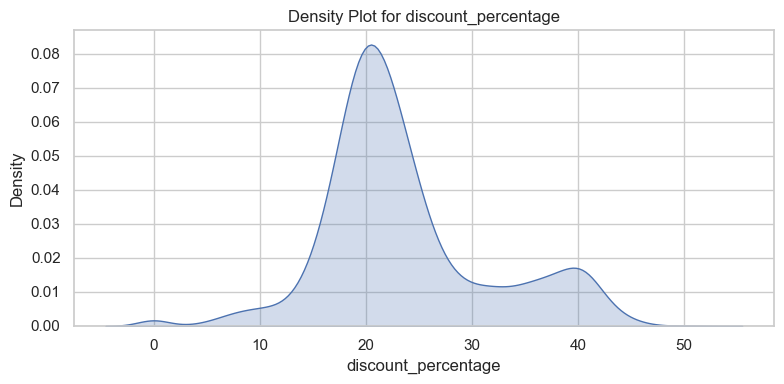

total_order_count
Skew : 0.66


C:\Users\rijul\AppData\Local\Temp\ipykernel_12104\2749468202.py:17: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data_final_df_cleaned[col], shade=True)


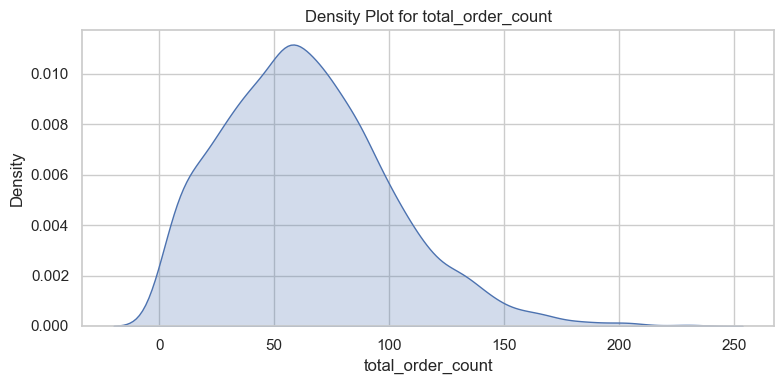

average_order_value
Skew : 1.74


C:\Users\rijul\AppData\Local\Temp\ipykernel_12104\2749468202.py:17: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data_final_df_cleaned[col], shade=True)


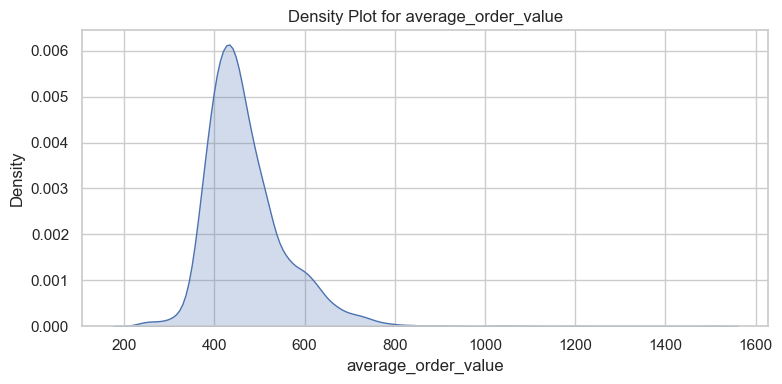

day_of_week
Skew : -0.0


C:\Users\rijul\AppData\Local\Temp\ipykernel_12104\2749468202.py:17: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data_final_df_cleaned[col], shade=True)


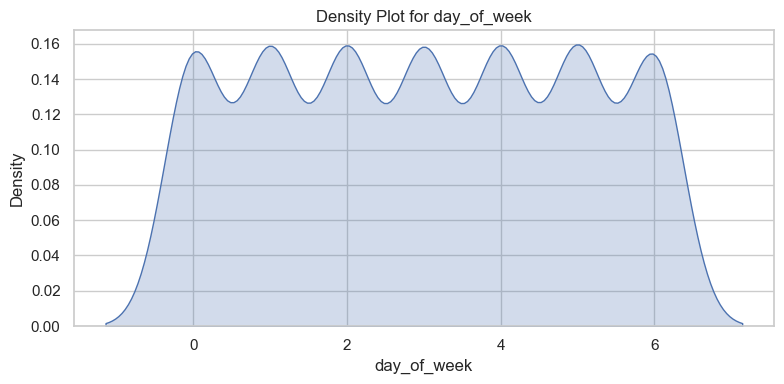

week_of_year
Skew : 0.38


C:\Users\rijul\AppData\Local\Temp\ipykernel_12104\2749468202.py:17: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data_final_df_cleaned[col], shade=True)


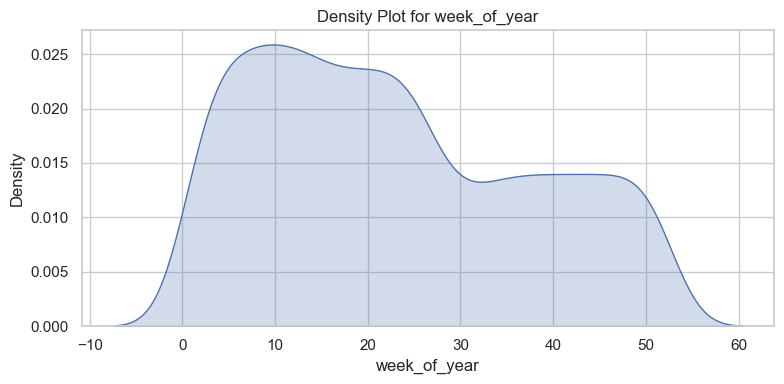

month
Skew : 0.38


C:\Users\rijul\AppData\Local\Temp\ipykernel_12104\2749468202.py:17: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data_final_df_cleaned[col], shade=True)


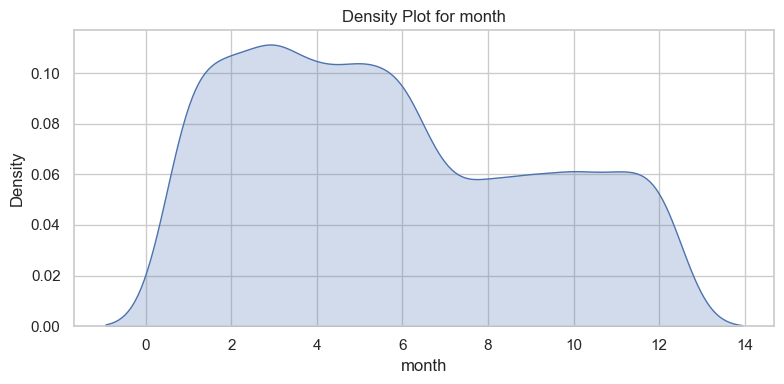

year
Skew : 0.46


C:\Users\rijul\AppData\Local\Temp\ipykernel_12104\2749468202.py:17: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data_final_df_cleaned[col], shade=True)


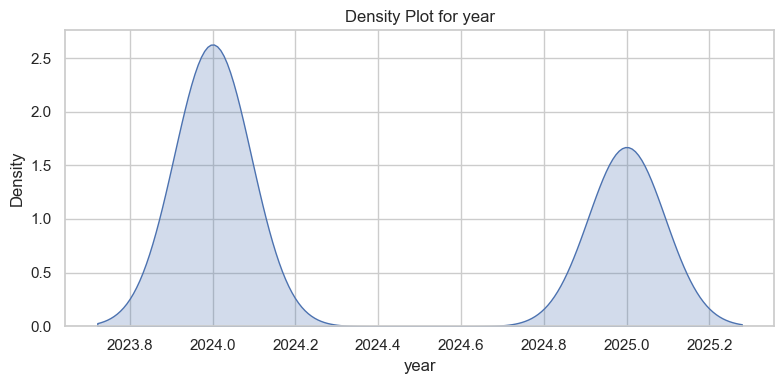

day_of_month
Skew : 0.0


C:\Users\rijul\AppData\Local\Temp\ipykernel_12104\2749468202.py:17: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data_final_df_cleaned[col], shade=True)


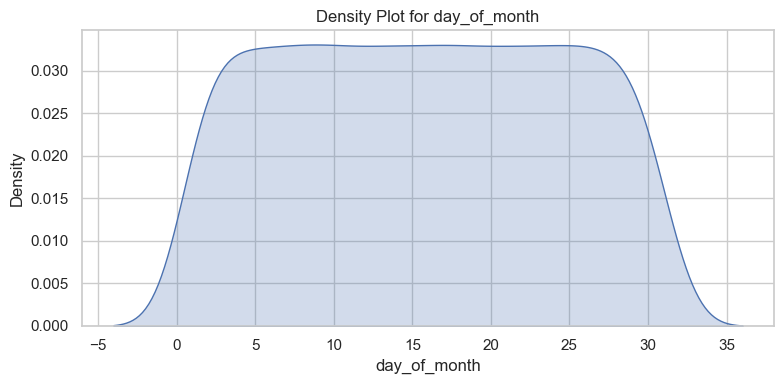

quarter
Skew : 0.41


C:\Users\rijul\AppData\Local\Temp\ipykernel_12104\2749468202.py:17: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data_final_df_cleaned[col], shade=True)


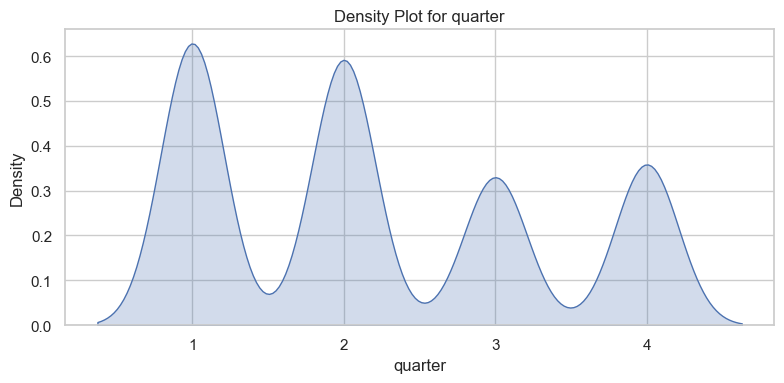

temperature_avg
Skew : -0.28


C:\Users\rijul\AppData\Local\Temp\ipykernel_12104\2749468202.py:17: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data_final_df_cleaned[col], shade=True)


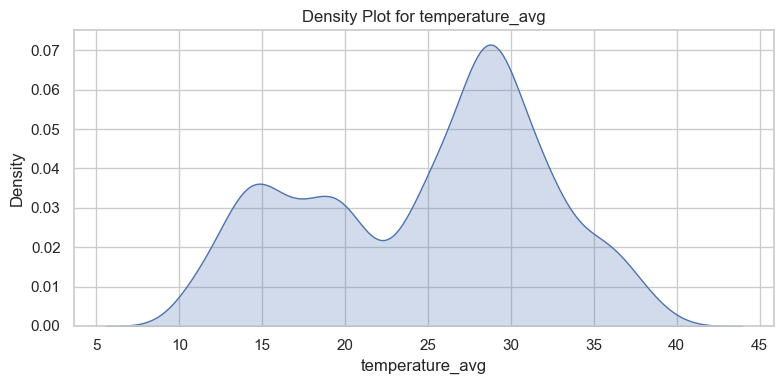

humidity_avg
Skew : -0.47


C:\Users\rijul\AppData\Local\Temp\ipykernel_12104\2749468202.py:17: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data_final_df_cleaned[col], shade=True)


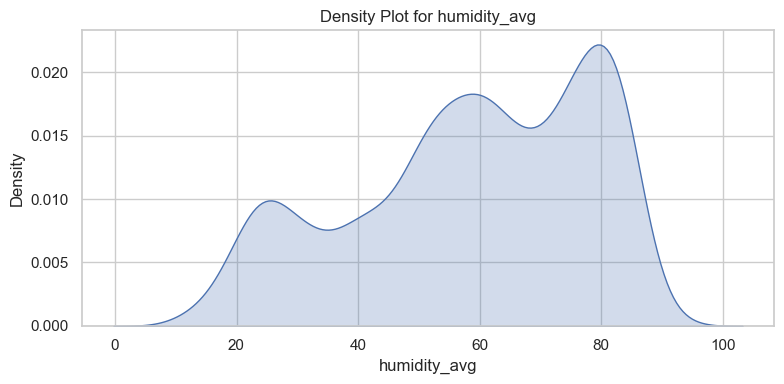

precipitation_sum
Skew : 15.27


C:\Users\rijul\AppData\Local\Temp\ipykernel_12104\2749468202.py:17: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data_final_df_cleaned[col], shade=True)


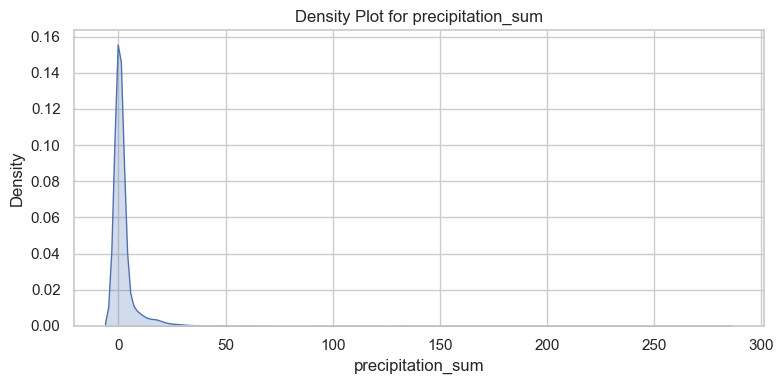

In [318]:
for col in num_cols:
    print(col)
    print('Skew :', round(data_final_df_cleaned[col].skew(), 2))
    plt.figure(figsize = (15, 4))
    plt.subplot(1, 2, 1)
    data_final_df_cleaned[col].hist(grid=False)
    plt.ylabel('count')
    plt.subplot(1, 2, 2)
    sns.boxplot(x=data_final_df_cleaned[col])
    plt.show()

for col in num_cols:
    print(f"{col}")
    print('Skew :', round(data_final_df_cleaned[col].skew(), 2))

    plt.figure(figsize=(8, 4))
    sns.kdeplot(data_final_df_cleaned[col], shade=True)
    plt.title(f'Density Plot for {col}')
    plt.xlabel(col)
    plt.ylabel('Density')
    plt.tight_layout()
    plt.show()


In [319]:
# # Replace with your actual list of numeric columns if not already defined
# numeric_features = data_final_df.select_dtypes(include='number').columns

# # Perform normality test
# for i in numeric_features:
#     stat, p = normaltest(data_final_df[i].dropna().values)
#     result = "Not Gaussian" if p < 0.05 else "Gaussian"
#     print(f'{i}: {result} (stat={stat:.2f}, p={p:.4f})')
# # Automatically get numeric columns (or use your own list)
# numeric_features = data_final_df.select_dtypes(include='number').columns

# # Plot Q–Q plots
# for col in numeric_features:
#     plt.figure(figsize=(6, 6))
#     stats.probplot(data_final_df[col].dropna(), dist="norm", plot=plt)
#     plt.title(f'Q–Q Plot of {col}')
#     plt.xlabel('Theoretical Quantiles')
#     plt.ylabel('Sample Quantiles')
#     plt.grid(True)
#     plt.tight_layout()
#     plt.show()


In [320]:
# # Ensure datetime format
# data_final_df_cleaned['order_date'] = pd.to_datetime(data_final_df_cleaned['order_date'])

# # Get list of unique outlets
# unique_outlets = data_final_df_cleaned['branch_name'].unique()

# for branch_name in unique_outlets:
#     outlet_df = data_final_df_cleaned[data_final_df['branch_name'] == branch_name].copy()
#     outlet_df = outlet_df.sort_values('order_date')

#     # Skip if not enough data
#     if outlet_df.empty:
#         continue

#     # Get start and end date
#     start_date = outlet_df['order_date'].min().strftime('%d-%b-%Y')
#     end_date = outlet_df['order_date'].max().strftime('%d-%b-%Y')

#     # Plot
#     plt.figure(figsize=(14, 6))
#     sns.lineplot(data=outlet_df, x='order_date', y='total_gross_sales', marker='o')

#     # Title with date range
#     plt.title(f"Sales Trend for '{branch_name}'\n({start_date} to {end_date})", fontsize=14)
#     plt.xlabel("Order Date")
#     plt.ylabel("Total Gross Sales")

#     plt.gca().xaxis.set_major_locator(MonthLocator())
#     plt.gca().xaxis.set_major_formatter(DateFormatter("%b-%Y"))

#     plt.xticks(rotation=45)
#     plt.grid(True)
#     plt.tight_layout()
#     plt.show()


In [321]:
import pandas as pd

# Define the date range
start_date = pd.to_datetime('2024-06-01')
end_date = pd.to_datetime('2025-05-31')

# Ensure order_date is datetime
data_final_df_cleaned['order_date'] = pd.to_datetime(data_final_df_cleaned['order_date'], errors='coerce')

# Filter data within the date range
filtered_df = data_final_df_cleaned[
    (data_final_df_cleaned['order_date'] >= start_date) & 
    (data_final_df_cleaned['order_date'] <= end_date)
].copy()

# Create year-month column for grouping
filtered_df['year_month'] = filtered_df['order_date'].dt.to_period('M')

# Step 1: Group by branch_name and year_month to count unique days
days_per_month = (
    filtered_df
    .groupby(['branch_name', 'year_month'])['order_date']
    .nunique()
    .reset_index(name='days_present')
)

# Step 2: Keep only those rows where branch has ≥22 days in that month
valid_months = days_per_month[days_per_month['days_present'] >= 22]

# Step 3: Count number of valid months per branch
valid_month_counts = valid_months.groupby('branch_name')['year_month'].nunique().reset_index(name='valid_months')

# Step 4: Total number of months in the range
total_months = len(pd.period_range(start=start_date, end=end_date, freq='M'))

# Step 5: Get branch_names that have all required months with ≥22 days
valid_branch_names = valid_month_counts[valid_month_counts['valid_months'] == total_months]['branch_name']

# Final Output
print(f"Number of branch_names with ≥22 days of data for each month from June 2024 to June 2025: {len(valid_branch_names)}")
print("Qualified branch_names:")
print(valid_branch_names.tolist())


Number of branch_names with ≥22 days of data for each month from June 2024 to June 2025: 6
Qualified branch_names:
['Dannys Fried Chicken Gk1', 'Dannys Fried Chicken Mayur Vihar Phase 1', 'Dannys Fried Chickenashok Vihar', 'Dannys Fried Chickennoida Sec 73', 'Dannys Fried Chickenrodeo Drive', 'Dannys Fried Chickenvasant Kunj']


In [322]:

# Filter original filtered_df to keep only valid branches
final_df = filtered_df[filtered_df['branch_name'].isin(valid_branch_names.tolist())].copy()

# Optional: sort for better readability
final_df.sort_values(by=['branch_name', 'order_date'], inplace=True)

# Show the final DataFrame
display(final_df.head())


,brand_id,brand_name,city,branch_name,order_date,total_gross_sales,discount_percentage,total_order_count,average_order_value,is_holiday,day_type,season,day_of_week,week_of_year,month,year,day_of_month,is_weekend,quarter,temperature_avg,humidity_avg,precipitation_sum,weather_condition,year_month
349,1039,Dannys Fried Chicken,Delhi,Dannys Fried Chicken Gk1,2024-06-01,34487.0,21.69,84,410.56,False,Weekend,Summer,5,22,6,2024,1,True,2,37.50,18.0,0.0,Overcast,2024-06
350,1039,Dannys Fried Chicken,Delhi,Dannys Fried Chicken Gk1,2024-06-02,30109.0,23.61,80,376.36,False,Weekend,Summer,6,22,6,2024,2,True,2,36.60,26.0,0.0,Overcast,2024-06
351,1039,Dannys Fried Chicken,Delhi,Dannys Fried Chicken Gk1,2024-06-03,57540.0,38.82,115,500.35,False,Weekday,Summer,0,23,6,2024,3,False,2,37.20,28.0,0.0,Partly cloudy,2024-06
352,1039,Dannys Fried Chicken,Delhi,Dannys Fried Chicken Gk1,2024-06-04,25465.0,22.25,61,417.46,False,Weekday,Summer,1,23,6,2024,4,False,2,36.85,21.5,0.0,Mainly clear,2024-06
353,1039,Dannys Fried Chicken,Delhi,Dannys Fried Chicken Gk1,2024-06-05,36447.0,19.53,83,439.12,False,Weekday,Summer,2,23,6,2024,5,False,2,36.25,24.0,0.0,Partly cloudy,2024-06


In [323]:

final_df.shape


(2186, 24)

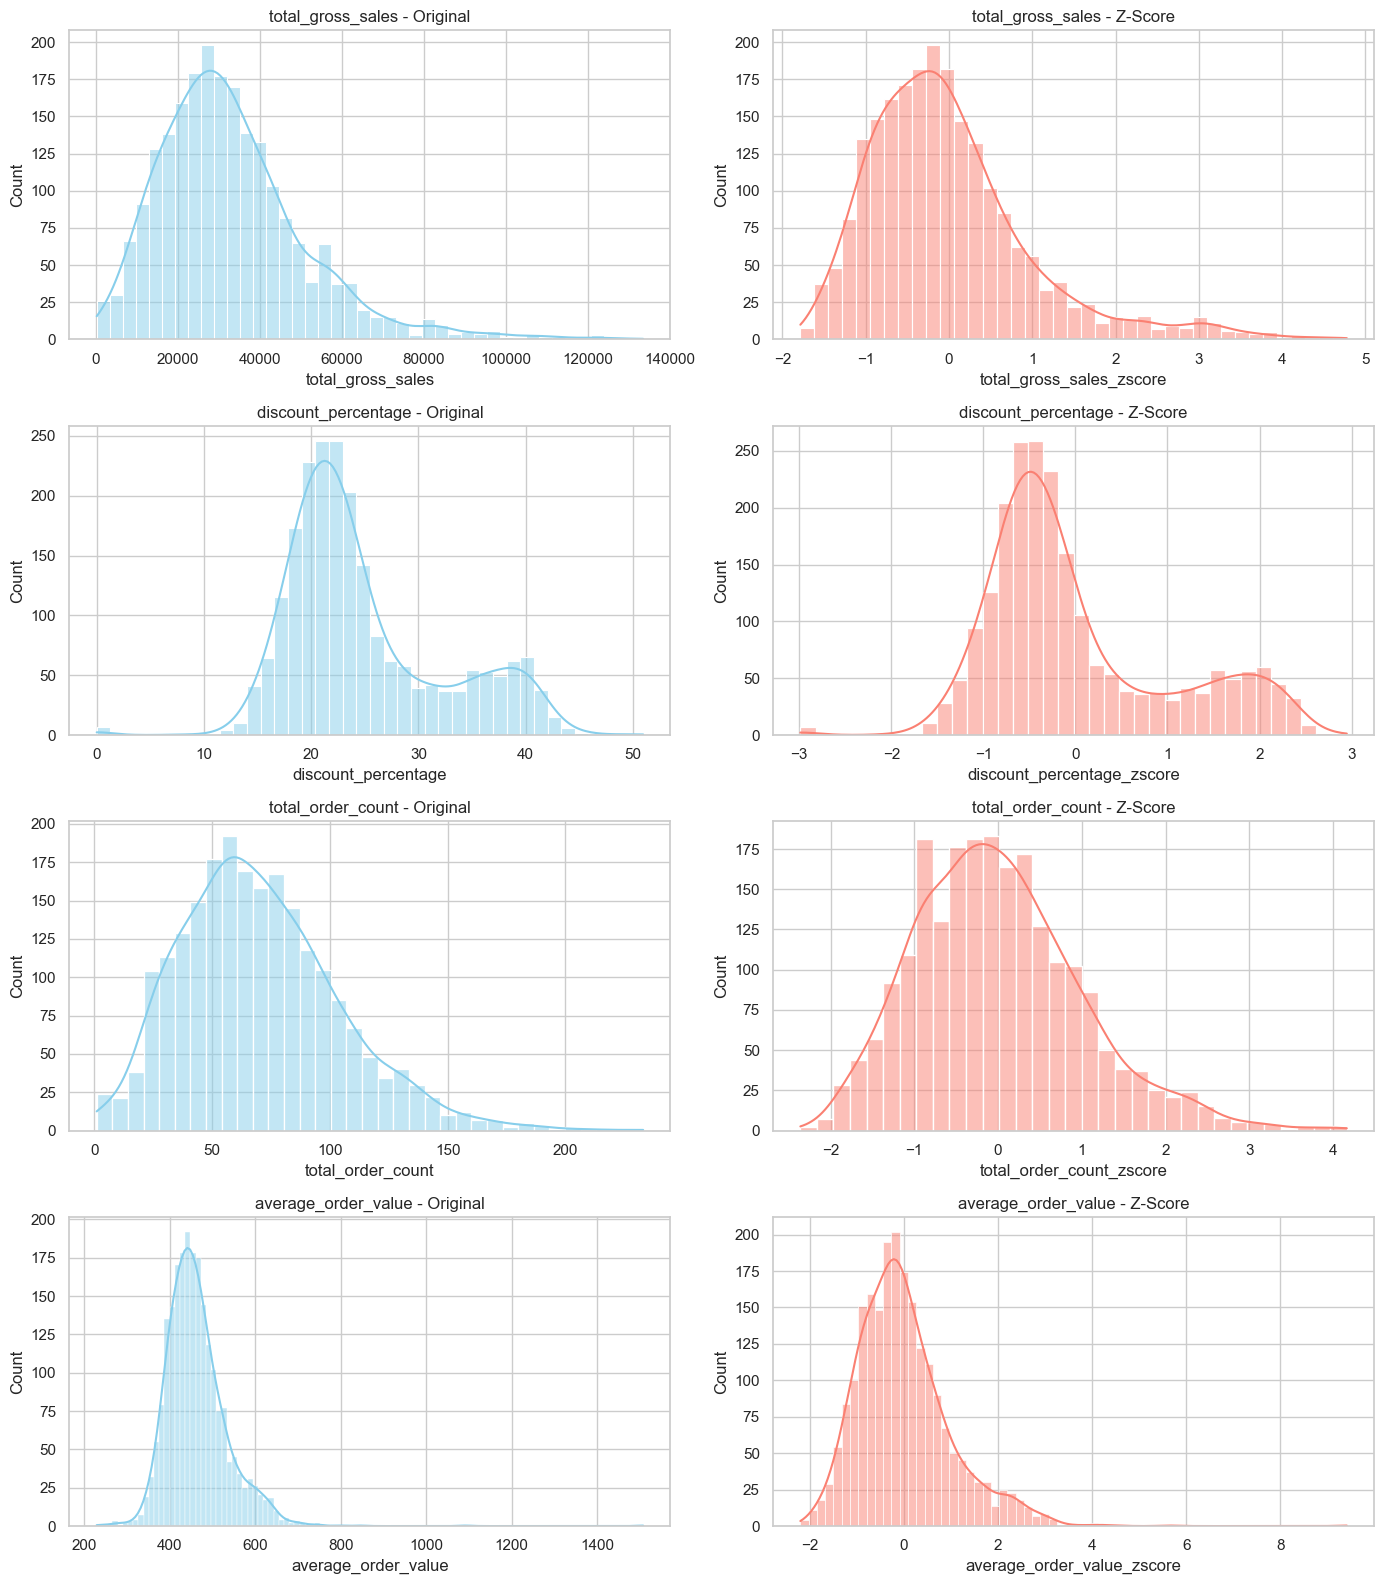

In [324]:
import matplotlib.pyplot as plt
import seaborn as sns

# List of metrics to standardize
metrics = ['total_gross_sales', 'discount_percentage', 'total_order_count', 'average_order_value']

# Calculate z-score for each metric per branch
for metric in metrics:
    z_col = f"{metric}_zscore"
    final_df[z_col] = final_df.groupby('branch_name')[metric].transform(
        lambda x: (x - x.mean()) / x.std()
    )

# Plotting
fig, axes = plt.subplots(len(metrics), 2, figsize=(14, 4 * len(metrics)))

for i, metric in enumerate(metrics):
    # Original
    sns.histplot(final_df[metric], kde=True, ax=axes[i][0], color='skyblue')
    axes[i][0].set_title(f"{metric} - Original")

    # Z-Score
    z_col = f"{metric}_zscore"
    sns.histplot(final_df[z_col], kde=True, ax=axes[i][1], color='salmon')
    axes[i][1].set_title(f"{metric} - Z-Score")

plt.tight_layout()
plt.show()


In [325]:
from scipy.stats import zscore

# Step 1: Store original row count
original_rows = len(final_df)

# Step 2: Define columns to check
columns_to_check = ['total_gross_sales', 'discount_percentage', 'total_order_count', 'average_order_value']

# Step 3: Create z-score columns per branch
for col in columns_to_check:
    z_col = col + '_zscore'
    final_df[z_col] = final_df.groupby('branch_name')[col].transform(zscore)

# Step 4: Condition to keep rows where all z-scores are within ±3
condition = (final_df[[col + '_zscore' for col in columns_to_check]].abs() <= 3).all(axis=1)

# Step 5: Print row counts
rows_after = condition.sum()
print(f"Rows before removing outliers: {original_rows}")
print(f"Rows after removing outliers: {rows_after}")
print(f"Outliers removed: {original_rows - rows_after}")


Rows before removing outliers: 2186
Rows after removing outliers: 2129
Outliers removed: 57


In [326]:
final_df.head()

,brand_id,brand_name,city,branch_name,order_date,total_gross_sales,discount_percentage,total_order_count,average_order_value,is_holiday,day_type,season,day_of_week,week_of_year,month,year,day_of_month,is_weekend,quarter,temperature_avg,humidity_avg,precipitation_sum,weather_condition,year_month,total_gross_sales_zscore,discount_percentage_zscore,total_order_count_zscore,average_order_value_zscore
349,1039,Dannys Fried Chicken,Delhi,Dannys Fried Chicken Gk1,2024-06-01,34487.0,21.69,84,410.56,False,Weekend,Summer,5,22,6,2024,1,True,2,37.50,18.0,0.0,Overcast,2024-06,-0.437673,-0.545739,-0.248608,-0.705442
350,1039,Dannys Fried Chicken,Delhi,Dannys Fried Chicken Gk1,2024-06-02,30109.0,23.61,80,376.36,False,Weekend,Summer,6,22,6,2024,2,True,2,36.60,26.0,0.0,Overcast,2024-06,-0.704686,-0.273636,-0.405263,-1.280167
351,1039,Dannys Fried Chicken,Delhi,Dannys Fried Chicken Gk1,2024-06-03,57540.0,38.82,115,500.35,False,Weekday,Summer,0,23,6,2024,3,False,2,37.20,28.0,0.0,Partly cloudy,2024-06,0.968324,1.881926,0.965464,0.803461
352,1039,Dannys Fried Chicken,Delhi,Dannys Fried Chicken Gk1,2024-06-04,25465.0,22.25,61,417.46,False,Weekday,Summer,1,23,6,2024,4,False,2,36.85,21.5,0.0,Mainly clear,2024-06,-0.987923,-0.466375,-1.149372,-0.589489
353,1039,Dannys Fried Chicken,Delhi,Dannys Fried Chicken Gk1,2024-06-05,36447.0,19.53,83,439.12,False,Weekday,Summer,2,23,6,2024,5,False,2,36.25,24.0,0.0,Partly cloudy,2024-06,-0.318133,-0.851854,-0.287772,-0.225497


In [327]:

# Step 6: Create cleaned copy
final_df_cleaned = final_df[condition].copy()


In [328]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

# Step 1: Select features
feature_cols = [
    'discount_percentage_zscore',
    'total_order_count_zscore',
    'average_order_value_zscore',
    'is_holiday', 'day_type', 'season', 'day_of_week',
    'week_of_year', 'month', 'year', 'day_of_month',
    'quarter', 'temperature_avg', 'humidity_avg', 'precipitation_sum',
    'weather_condition'
]

target_col = 'total_gross_sales_zscore'

# Step 2: Extract feature and target data
X = final_df_cleaned[feature_cols].copy()
y = final_df_cleaned[target_col].copy()

# Step 3: Identify numeric and categorical columns
categorical_cols = ['day_type', 'season', 'weather_condition']
numeric_cols = [col for col in feature_cols if col not in categorical_cols]

# Step 4: Fix common issues
# Convert string "False"/"True" to 0/1 and cast to float
for col in numeric_cols:
    X[col] = X[col].replace({'False': 0, 'True': 1})
    X[col] = pd.to_numeric(X[col], errors='coerce')

# Ensure categoricals are string type
for col in categorical_cols:
    X[col] = X[col].astype(str)

# Final NaN check
if X.isnull().sum().sum() > 0:
    print("NaNs found before transformation:\n", X.isnull().sum())
    raise ValueError("Fix NaNs before continuing.")

# Step 5: Preprocessing pipeline
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

# Step 6: Fit and transform
X_processed = preprocessor.fit_transform(X)

# Step 7: Train/test split
X_train_processed, X_test_processed, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.2, random_state=42
)

import lightgbm as lgb
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# 1. Prepare LightGBM datasets
train_data = lgb.Dataset(X_train_processed, label=y_train)
test_data = lgb.Dataset(X_test_processed, label=y_test, reference=train_data)

# 2. Define model parameters
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'seed': 42
}

# 3. Train the model
model = lgb.train(
    params,
    train_data,
    valid_sets=[train_data, test_data],
    num_boost_round=1000,
    # early_stopping_rounds=50,
    # verbose_eval=100
)

# 4. Make predictions
y_pred = model.predict(X_test_processed)

# 5. Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")



RMSE: 0.0680
R² Score: 0.9932


In [329]:
# Predict on training data
y_train_pred = model.predict(X_train_processed)

# Evaluate
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_r2 = r2_score(y_train, y_train_pred)

print(f"Train RMSE: {train_rmse:.4f}")
print(f"Train R² Score: {train_r2:.4f}")


Train RMSE: 0.0113
Train R² Score: 0.9998


In [330]:
import optuna
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

# 1. Split processed training data
X_train_sub, X_valid_sub, y_train_sub, y_valid_sub = train_test_split(
    X_train_processed, y_train, test_size=0.2, random_state=42
)

# 2. Define objective function
def objective(trial):
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.6, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.6, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'lambda_l1': trial.suggest_float('lambda_l1', 0.0, 5.0),
        'lambda_l2': trial.suggest_float('lambda_l2', 0.0, 5.0),
        'seed': 42
    }

    # Convert to LightGBM Dataset
    dtrain = lgb.Dataset(X_train_sub, label=y_train_sub)
    dvalid = lgb.Dataset(X_valid_sub, label=y_valid_sub)

    # Use callbacks only
    model = lgb.train(
        params,
        dtrain,
        valid_sets=[dvalid],
        num_boost_round=1000,
        callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)]
    )

    # Predict and evaluate
    y_pred = model.predict(X_valid_sub)
    import numpy as np
    rmse = np.sqrt(mean_squared_error(y_valid_sub, y_pred))

    return rmse

# 3. Run Optuna optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# 4. Output best results
print("\nBest trial:")
print(f"  RMSE: {study.best_value:.4f}")
print("  Best Params:")
for k, v in study.best_params.items():
    print(f"    {k}: {v}")


[I 2025-07-01 18:02:28,107] A new study created in memory with name: no-name-fd94b729-d0c3-45d3-aae8-4579d195ff1b


[I 2025-07-01 18:02:28,537] Trial 0 finished with value: 0.13551792158004422 and parameters: {'learning_rate': 0.050122804563933504, 'num_leaves': 133, 'feature_fraction': 0.7549751423342541, 'bagging_fraction': 0.7966961507935691, 'bagging_freq': 1, 'min_child_samples': 98, 'lambda_l1': 3.3017754931920322, 'lambda_l2': 2.1286551254271058}. Best is trial 0 with value: 0.13551792158004422.
[I 2025-07-01 18:02:28,694] Trial 1 finished with value: 0.1303282584098839 and parameters: {'learning_rate': 0.13860254263431782, 'num_leaves': 107, 'feature_fraction': 0.8209373011913419, 'bagging_fraction': 0.7064762033269022, 'bagging_freq': 9, 'min_child_samples': 79, 'lambda_l1': 4.124748114619841, 'lambda_l2': 3.045858840283407}. Best is trial 1 with value: 0.1303282584098839.
[I 2025-07-01 18:02:29,025] Trial 2 finished with value: 0.08923704436532519 and parameters: {'learning_rate': 0.10769388228355453, 'num_leaves': 89, 'feature_fraction': 0.6381929930124313, 'bagging_fraction': 0.824492981


Best trial:
  RMSE: 0.0617
  Best Params:
    learning_rate: 0.08899424149458703
    num_leaves: 62
    feature_fraction: 0.9961816704494312
    bagging_fraction: 0.6681606598167343
    bagging_freq: 5
    min_child_samples: 14
    lambda_l1: 0.013435791818066312
    lambda_l2: 2.2371363902788968


In [331]:
best_params = study.best_params
best_params.update({
    'objective': 'regression',
    'metric': 'rmse',
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'seed': 42
})

train_data = lgb.Dataset(X_train_processed, label=y_train)
model = lgb.train(
    best_params,
    train_data,
    num_boost_round=1000
)

# 5. Predict on test data
y_pred_test = model.predict(X_test_processed)

# 6. Evaluate
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2_test = r2_score(y_test, y_pred_test)

print(f"\nTest RMSE: {rmse_test:.4f}")
print(f"Test R² Score: {r2_test:.4f}")



Test RMSE: 0.0664
Test R² Score: 0.9935


In [332]:
sales_mean = final_df_cleaned['total_gross_sales'].mean()
sales_std = final_df_cleaned['total_gross_sales'].std()


In [333]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# 1. Predict
y_pred_test = model.predict(X_test_processed)

# 2. Inverse the z-score normalization
y_pred_actual = y_pred_test * sales_std + sales_mean
y_test_actual = y_test * sales_std + sales_mean

# 3. Evaluate
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))
r2 = r2_score(y_test_actual, y_pred_actual)

# 4. Print results
print(f"\nDe-normalized Test RMSE: {rmse:.2f}")
print(f"De-normalized Test R² Score: {r2:.4f}")



De-normalized Test RMSE: 1074.50
De-normalized Test R² Score: 0.9935


In [334]:
comparison_df = pd.DataFrame({
    'Actual Sales': y_test_actual,
    'Predicted Sales': y_pred_actual
})
print(comparison_df.head(10))


      Actual Sales  Predicted Sales
640   66697.160321     68690.266379
3389  39175.851700     39440.762721
2907   7049.085942      8158.799545
2288  34793.917222     34496.295693
3409  28631.575685     28765.651327
655   39294.757243     38646.378863
2940  26037.275405     25593.296505
2616  27410.724348     25978.039171
419   32840.763398     31045.252038
648   43598.692912     43275.863843


In [335]:
overall_mape = np.mean(np.abs((y_test_actual - y_pred_actual) / y_test_actual)) * 100
print(f"Mean Absolute Percentage Error (MAPE): {overall_mape:.2f}%")


Mean Absolute Percentage Error (MAPE): 2.54%


In [336]:
# Step 1: Prepare the latest (tomorrow’s) data row for prediction
# Ensure same feature columns as used in training
tomorrow_features = final_df_cleaned[feature_cols].copy().tail(1)

# Apply the same preprocessing pipeline
tomorrow_processed = preprocessor.transform(tomorrow_features)

# Step 2: Predict using trained model
tomorrow_pred_zscore = model.predict(tomorrow_processed)

# Step 3: Inverse z-score to get predicted sales
tomorrow_pred_sales = tomorrow_pred_zscore[0] * sales_std + sales_mean

# Step 4: Extract branch name and tomorrow’s date
branch_name = final_df_cleaned['branch_name'].iloc[-1]
last_date = pd.to_datetime(final_df_cleaned['order_date'].iloc[-1])
tomorrow_date = last_date + pd.Timedelta(days=1)

# Step 5: Print result
print("\n📅 Tomorrow's Sales Prediction")
print(f"Branch Name   : {branch_name}")
print(f"Order Date    : {tomorrow_date.date()}")
print(f"Predicted Sales: ₹{tomorrow_pred_sales:.2f}")



📅 Tomorrow's Sales Prediction
Branch Name   : Dannys Fried Chickenvasant Kunj
Order Date    : 2025-06-01
Predicted Sales: ₹33253.17


In [338]:
from datetime import datetime, timedelta

# 1. Set tomorrow's date
tomorrow_date = (datetime.now().date() + timedelta(days=1)).strftime('%Y-%m-%d')

# 2. Pick the latest available rows for Amritsar and Panchkula
latest_amritsar = final_df_cleaned[final_df_cleaned['branch_name'] == 'Dannys Fried Chicken Gk1'].copy().sort_values('order_date').iloc[-1]
latest_panchkula = final_df_cleaned[final_df_cleaned['branch_name'] == 'Dannys Fried Chickenashok Vihar'].copy().sort_values('order_date').iloc[-1]

# 3. Update order_date to tomorrow
latest_amritsar['order_date'] = tomorrow_date
latest_panchkula['order_date'] = tomorrow_date

# 4. Create dataframe for both branches
tomorrow_df = pd.DataFrame([latest_amritsar, latest_panchkula])

# 5. Keep only required features and preprocess
X_tomorrow = tomorrow_df[feature_cols].copy()

# Handle conversions for consistency
for col in numeric_cols:
    X_tomorrow[col] = X_tomorrow[col].replace({'False': 0, 'True': 1})
    X_tomorrow[col] = pd.to_numeric(X_tomorrow[col], errors='coerce')
for col in categorical_cols:
    X_tomorrow[col] = X_tomorrow[col].astype(str)

# Final check
if X_tomorrow.isnull().sum().sum() > 0:
    raise ValueError("Missing values in tomorrow's prediction features!")

# 6. Transform features
X_tomorrow_processed = preprocessor.transform(X_tomorrow)

# 7. Predict
zscore_preds = model.predict(X_tomorrow_processed)
actual_preds = zscore_preds * sales_std + sales_mean

# 8. Combine results
tomorrow_df['predicted_sales'] = actual_preds
output = tomorrow_df[['branch_name', 'order_date', 'predicted_sales']]
output['predicted_sales'] = output['predicted_sales'].round(2)

print("\n📅 Tomorrow's Sales Predictions:\n")
print(output)



📅 Tomorrow's Sales Predictions:

                          branch_name  order_date  predicted_sales
713          Dannys Fried Chicken Gk1  2025-07-02         22930.94
1631  Dannys Fried Chickenashok Vihar  2025-07-02         34537.74


C:\Users\rijul\AppData\Local\Temp\ipykernel_12104\1057290440.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  output['predicted_sales'] = output['predicted_sales'].round(2)


In [339]:

# 1. Get rows for Panchkula and Amritsar
branches_of_interest = ['Dannys Fried Chickenashok Vihar', 'Dannys Fried Chicken Gk1']
filtered_raw_df = final_df_cleaned[final_df_cleaned['branch_name'].isin(branches_of_interest)].copy()

# 2. Drop the target column if present (e.g., 'sales')
X_filtered = filtered_raw_df.drop(columns=['total_gross_sales_zscore'])  # replace 'sales' with your actual target name

# 3. Apply the same preprocessor
X_filtered_processed = preprocessor.transform(X_filtered)

# 4. Predict
predicted_sales = model.predict(X_filtered_processed)

# 5. Show results
filtered_raw_df['predicted_sales'] = predicted_sales
print(filtered_raw_df[['branch_name','order_date','total_gross_sales_zscore' ,'predicted_sales']])


                          branch_name order_date  total_gross_sales_zscore  \
349          Dannys Fried Chicken Gk1 2024-06-01                 -0.437673   
350          Dannys Fried Chicken Gk1 2024-06-02                 -0.704686   
351          Dannys Fried Chicken Gk1 2024-06-03                  0.968324   
352          Dannys Fried Chicken Gk1 2024-06-04                 -0.987923   
353          Dannys Fried Chicken Gk1 2024-06-05                 -0.318133   
354          Dannys Fried Chicken Gk1 2024-06-06                 -0.946693   
355          Dannys Fried Chicken Gk1 2024-06-07                 -0.285320   
356          Dannys Fried Chicken Gk1 2024-06-08                 -0.159986   
357          Dannys Fried Chicken Gk1 2024-06-09                 -0.505493   
358          Dannys Fried Chicken Gk1 2024-06-10                 -0.646746   
359          Dannys Fried Chicken Gk1 2024-06-11                 -1.167476   
360          Dannys Fried Chicken Gk1 2024-06-12                

In [340]:

z_scores = filtered_raw_df['predicted_sales']  # this is in z-score form

# Use the same values used for standardization
mean_sales = y_train.mean()
std_sales = y_train.std()

# Inverse transformation
filtered_raw_df['predicted_sales_actual'] = z_scores * std_sales + mean_sales

print(filtered_raw_df[['branch_name','order_date','total_gross_sales', 'predicted_sales_actual']])


                          branch_name order_date  total_gross_sales  \
349          Dannys Fried Chicken Gk1 2024-06-01           34487.00   
350          Dannys Fried Chicken Gk1 2024-06-02           30109.00   
351          Dannys Fried Chicken Gk1 2024-06-03           57540.00   
352          Dannys Fried Chicken Gk1 2024-06-04           25465.00   
353          Dannys Fried Chicken Gk1 2024-06-05           36447.00   
354          Dannys Fried Chicken Gk1 2024-06-06           26141.00   
355          Dannys Fried Chicken Gk1 2024-06-07           36985.00   
356          Dannys Fried Chicken Gk1 2024-06-08           39040.00   
357          Dannys Fried Chicken Gk1 2024-06-09           33375.00   
358          Dannys Fried Chicken Gk1 2024-06-10           31059.00   
359          Dannys Fried Chicken Gk1 2024-06-11           22521.00   
360          Dannys Fried Chicken Gk1 2024-06-12           32467.00   
361          Dannys Fried Chicken Gk1 2024-06-13           38963.00   
362   

In [341]:

# 1. Get Panchkula and Amritsar rows
branches_of_interest = ['Dannys Fried Chicken Gk1', 'Dannys Fried Chickenashok Vihar']
filtered_raw_df = final_df_cleaned[final_df_cleaned['branch_name'].isin(branches_of_interest)].copy()

# 2. Drop z-score target column before preprocessing
X_filtered = filtered_raw_df.drop(columns=['total_gross_sales_zscore'])

# 3. Preprocess and predict
X_filtered_processed = preprocessor.transform(X_filtered)
filtered_raw_df['predicted_sales'] = model.predict(X_filtered_processed)

# 4. Get branch-wise mean and std from full cleaned dataset
branch_stats = final_df_cleaned.groupby('branch_name')['total_gross_sales'].agg(['mean', 'std']).rename(
    columns={'mean': 'branch_mean', 'std': 'branch_std'}
)

# 5. Merge mean & std into the filtered dataframe
filtered_raw_df = filtered_raw_df.merge(branch_stats, on='branch_name', how='left')

# 6. Inverse z-score: predicted and actual
filtered_raw_df['predicted_sales_actual'] = (
    filtered_raw_df['predicted_sales'] * filtered_raw_df['branch_std'] + filtered_raw_df['branch_mean']
)

filtered_raw_df['total_gross_sales_actual'] = (
    filtered_raw_df['total_gross_sales_zscore'] * filtered_raw_df['branch_std'] + filtered_raw_df['branch_mean']
)

# 7. Display results
print(filtered_raw_df[[
    'branch_name', 'order_date', 'total_gross_sales_actual', 'predicted_sales_actual'
]])


                         branch_name order_date  total_gross_sales_actual  \
0           Dannys Fried Chicken Gk1 2024-06-01              34121.118236   
1           Dannys Fried Chicken Gk1 2024-06-02              30478.515410   
2           Dannys Fried Chicken Gk1 2024-06-03              53301.776743   
3           Dannys Fried Chicken Gk1 2024-06-04              26614.594094   
4           Dannys Fried Chicken Gk1 2024-06-05              35751.886061   
5           Dannys Fried Chicken Gk1 2024-06-06              27177.042589   
6           Dannys Fried Chicken Gk1 2024-06-07              36199.515189   
7           Dannys Fried Chicken Gk1 2024-06-08              37909.325332   
8           Dannys Fried Chicken Gk1 2024-06-09              33195.907103   
9           Dannys Fried Chicken Gk1 2024-06-10              31268.938591   
10          Dannys Fried Chicken Gk1 2024-06-11              24165.114259   
11          Dannys Fried Chicken Gk1 2024-06-12              32440.428947   

In [342]:
from datetime import timedelta
import pandas as pd

# Step 1: Get tomorrow's date and day-related features
tomorrow = pd.Timestamp.today().normalize() + pd.Timedelta(days=1)
day_of_week = tomorrow.dayofweek
week_of_year = tomorrow.isocalendar().week
month = tomorrow.month
year = tomorrow.year
day_of_month = tomorrow.day
quarter = (month - 1) // 3 + 1
is_weekend = 1 if day_of_week >= 5 else 0

# Step 2: Branches of interest
branches_of_interest = ['Dannys Fried Chickenashok Vihar', 'Dannys Fried Chicken Gk1']

# Step 3: Features used in the model
feature_cols = [
    'discount_percentage_zscore',
    'total_order_count_zscore',
    'average_order_value_zscore',
    'is_holiday', 'day_type', 'season', 'day_of_week',
    'week_of_year', 'month', 'year', 'day_of_month', 'is_weekend',
    'quarter', 'temperature_avg', 'humidity_avg', 'precipitation_sum',
    'weather_condition'
]

# Step 4: Build future input DataFrame
rows = []
for branch in branches_of_interest:
    branch_df = final_df_cleaned[final_df_cleaned['branch_name'] == branch]

    row = {
        'branch_name': branch,
        'order_date': tomorrow,
        'day_of_week': int(day_of_week),
        'week_of_year': int(week_of_year),
        'month': int(month),
        'year': int(year),
        'day_of_month': int(day_of_month),
        'quarter': int(quarter),
        'is_weekend': int(is_weekend)
    }

    for col in feature_cols:
        if col in row:
            continue
        if col in branch_df.columns:
            if branch_df[col].dtype.kind in 'biufc':
                row[col] = float(branch_df[col].mean())
            else:
                row[col] = str(branch_df[col].mode()[0]) if not branch_df[col].mode().empty else 'Unknown'
        else:
            row[col] = 0 if col not in ['day_type', 'season', 'weather_condition'] else 'Unknown'
    
    rows.append(row)

future_df = pd.DataFrame(rows)

# Step 5: Prepare input for model
X_future = future_df[feature_cols].copy()

# Ensure categorical columns are strings
categorical_cols = ['day_type', 'season', 'weather_condition']
X_future[categorical_cols] = X_future[categorical_cols].astype(str)

# Ensure numeric columns are floats/ints
numeric_cols = [col for col in feature_cols if col not in categorical_cols]
X_future[numeric_cols] = X_future[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Final NaN check
if X_future.isnull().sum().sum() > 0:
    print("Missing values detected in:")
    print(X_future.isnull().sum()[X_future.isnull().sum() > 0])
    raise ValueError("NaNs detected in model input after type casting")

# Step 6: Transform and predict
X_future_processed = preprocessor.transform(X_future)
predicted_z_scores = model.predict(X_future_processed)

# Step 7: Invert z-score to get predicted sales
future_df['predicted_sales_zscore'] = predicted_z_scores
future_df = future_df.merge(branch_stats, on='branch_name', how='left')
future_df['predicted_sales'] = (
    future_df['predicted_sales_zscore'] * future_df['branch_std'] + future_df['branch_mean']
)

# Final Output
print(future_df[['branch_name', 'order_date', 'predicted_sales']])


                       branch_name order_date  predicted_sales
0  Dannys Fried Chickenashok Vihar 2025-07-02     25184.762027
1         Dannys Fried Chicken Gk1 2025-07-02     38551.198373


# 10 DAYS PREDICTION

In [ ]:
import pandas as pd
from datetime import timedelta

# --- USER INPUT ---
start_date_str = '2025-06-20'  # <-- Replace with actual user input
end_date_str = '2025-06-30'    # <-- Replace with actual user input
branches_of_interest = ['Panchkula', 'Amritsar']

# --- DATE RANGE GENERATION ---
start_date = pd.to_datetime(start_date_str).normalize()
end_date = pd.to_datetime(end_date_str).normalize()
user_dates = pd.date_range(start=start_date, end=end_date).tolist()

# --- MODEL FEATURES ---
feature_cols = [
    'discount_percentage_zscore',
    'total_order_count_zscore',
    'average_order_value_zscore',
    'is_holiday', 'day_type', 'season', 'day_of_week',
    'week_of_year', 'month', 'year', 'day_of_month', 'is_weekend',
    'quarter', 'temperature_avg', 'humidity_avg', 'precipitation_sum',
    'weather_condition'
]

categorical_cols = ['day_type', 'season', 'weather_condition']
numeric_cols = [col for col in feature_cols if col not in categorical_cols]

# --- FUTURE DATAFRAME GENERATION ---
rows = []

for date in user_dates:
    day_of_week = date.dayofweek
    week_of_year = date.isocalendar().week
    month = date.month
    year = date.year
    day_of_month = date.day
    quarter = (month - 1) // 3 + 1
    is_weekend = 1 if day_of_week >= 5 else 0

    for branch in branches_of_interest:
        branch_df = final_df_cleaned[final_df_cleaned['branch_name'] == branch]

        row = {
            'branch_name': branch,
            'order_date': date,
            'day_of_week': int(day_of_week),
            'week_of_year': int(week_of_year),
            'month': int(month),
            'year': int(year),
            'day_of_month': int(day_of_month),
            'quarter': int(quarter),
            'is_weekend': int(is_weekend)
        }

        for col in feature_cols:
            if col in row:
                continue
            if col in branch_df.columns:
                if branch_df[col].dtype.kind in 'biufc':
                    row[col] = float(branch_df[col].mean())
                else:
                    row[col] = str(branch_df[col].mode()[0]) if not branch_df[col].mode().empty else 'Unknown'
            else:
                row[col] = 0 if col not in categorical_cols else 'Unknown'

        rows.append(row)

future_df = pd.DataFrame(rows)

# --- TYPE CASTING ---
X_future = future_df[feature_cols].copy()
X_future[categorical_cols] = X_future[categorical_cols].astype(str)
X_future[numeric_cols] = X_future[numeric_cols].apply(pd.to_numeric, errors='coerce')

# --- VALIDATION ---
if X_future.isnull().sum().sum() > 0:
    print("NaNs detected in:")
    print(X_future.isnull().sum()[X_future.isnull().sum() > 0])
    raise ValueError("Fix missing values before proceeding.")

# --- TRANSFORM AND PREDICT ---
X_future_processed = preprocessor.transform(X_future)
predicted_z_scores = model.predict(X_future_processed)

# --- INVERT Z-SCORE ---
future_df['predicted_sales_zscore'] = predicted_z_scores
future_df = future_df.merge(branch_stats, on='branch_name', how='left')
future_df['predicted_sales'] = (
    future_df['predicted_sales_zscore'] * future_df['branch_std'] + future_df['branch_mean']
)

# --- FINAL OUTPUT ---
print(future_df[['branch_name', 'order_date', 'predicted_sales']])


   branch_name order_date  predicted_sales
0    Panchkula 2025-06-20     52236.867386
1     Amritsar 2025-06-20     39094.813193
2    Panchkula 2025-06-21     52188.919963
3     Amritsar 2025-06-21     39053.661492
4    Panchkula 2025-06-22     52248.191377
5     Amritsar 2025-06-22     39103.804811
6    Panchkula 2025-06-23     52054.589952
7     Amritsar 2025-06-23     38999.052393
8    Panchkula 2025-06-24     51979.532662
9     Amritsar 2025-06-24     38941.409351
10   Panchkula 2025-06-25     51888.191781
11    Amritsar 2025-06-25     38866.321020
12   Panchkula 2025-06-26     51884.374674
13    Amritsar 2025-06-26     38839.872603
14   Panchkula 2025-06-27     52268.473230
15    Amritsar 2025-06-27     39139.828038
16   Panchkula 2025-06-28     52229.474915
17    Amritsar 2025-06-28     39107.712719
18   Panchkula 2025-06-29     52275.042024
19    Amritsar 2025-06-29     39114.590750
20   Panchkula 2025-06-30     52037.852163
21    Amritsar 2025-06-30     38984.559352


In [ ]:
# Step 1: Convert to datetime (if not already)
data_df['order_date'] = pd.to_datetime(data_df['order_date'])

# Step 2: Define filters
target_branches = ['Panchkula', 'Amritsar']
start_date = pd.to_datetime('2025-06-20')
end_date = pd.to_datetime('2025-06-30')

# Step 3: Filter the DataFrame
filtered_df = data_df[
    (data_df['branch_name'].isin(target_branches)) &
    (data_df['order_date'] >= start_date) &
    (data_df['order_date'] <= end_date)
]

# Step 4: Group by branch and date, then sum sales
daily_sales = (
    filtered_df
    .groupby(['branch_name', 'order_date'])['total_gross_sales']
    .sum()
    .reset_index()
    .sort_values(by=['branch_name', 'order_date'])
)

# Display result
print(daily_sales)


   branch_name order_date  total_gross_sales
0     Amritsar 2025-06-20           43532.23
1     Amritsar 2025-06-21           48939.19
2     Amritsar 2025-06-22           49957.70
3     Amritsar 2025-06-23           37259.84
4     Amritsar 2025-06-24           28809.70
5     Amritsar 2025-06-25           34441.95
6     Amritsar 2025-06-26           38821.30
7     Amritsar 2025-06-27           45516.97
8     Amritsar 2025-06-28           42277.93
9     Amritsar 2025-06-29           37873.89
10    Amritsar 2025-06-30           38171.90
11   Panchkula 2025-06-20           60512.72
12   Panchkula 2025-06-21           70927.54
13   Panchkula 2025-06-22           65215.58
14   Panchkula 2025-06-23           48598.51
15   Panchkula 2025-06-24           43571.74
16   Panchkula 2025-06-25           49771.90
17   Panchkula 2025-06-26           78283.15
18   Panchkula 2025-06-27           50919.94
19   Panchkula 2025-06-28           52158.70
20   Panchkula 2025-06-29           47218.55
21   Panch

In [ ]:
import pandas as pd

# Step 1: Ensure datetime format
data_df['order_date'] = pd.to_datetime(data_df['order_date'])
future_df['order_date'] = pd.to_datetime(future_df['order_date'])

# Step 2: Filter actual sales for desired branches and date range
target_branches = ['Panchkula', 'Amritsar']
start_date = future_df['order_date'].min()
end_date = future_df['order_date'].max()

filtered_actual = data_df[
    (data_df['branch_name'].isin(target_branches)) &
    (data_df['order_date'] >= start_date) &
    (data_df['order_date'] <= end_date)
]

# Step 3: Group actuals by branch and date
actual_sales = (
    filtered_actual
    .groupby(['branch_name', 'order_date'])['total_gross_sales']
    .sum()
    .reset_index()
    .rename(columns={'total_gross_sales': 'actual_sales'})
)

# Step 4: Prepare predicted sales
predicted_sales = future_df[['branch_name', 'order_date', 'predicted_sales']]

# Step 5: Merge both
comparison_df = pd.merge(
    actual_sales,
    predicted_sales,
    on=['branch_name', 'order_date'],
    how='outer'  # so we also see dates with missing actuals or predictions
)

# Step 6: Sort and display
comparison_df = comparison_df.sort_values(by=['branch_name', 'order_date']).reset_index(drop=True)

# Display result
print(comparison_df)


   branch_name order_date  actual_sales  predicted_sales
0     Amritsar 2025-06-20      43532.23     39094.813193
1     Amritsar 2025-06-21      48939.19     39053.661492
2     Amritsar 2025-06-22      49957.70     39103.804811
3     Amritsar 2025-06-23      37259.84     38999.052393
4     Amritsar 2025-06-24      28809.70     38941.409351
5     Amritsar 2025-06-25      34441.95     38866.321020
6     Amritsar 2025-06-26      38821.30     38839.872603
7     Amritsar 2025-06-27      45516.97     39139.828038
8     Amritsar 2025-06-28      42277.93     39107.712719
9     Amritsar 2025-06-29      37873.89     39114.590750
10    Amritsar 2025-06-30      38171.90     38984.559352
11   Panchkula 2025-06-20      60512.72     52236.867386
12   Panchkula 2025-06-21      70927.54     52188.919963
13   Panchkula 2025-06-22      65215.58     52248.191377
14   Panchkula 2025-06-23      48598.51     52054.589952
15   Panchkula 2025-06-24      43571.74     51979.532662
16   Panchkula 2025-06-25      

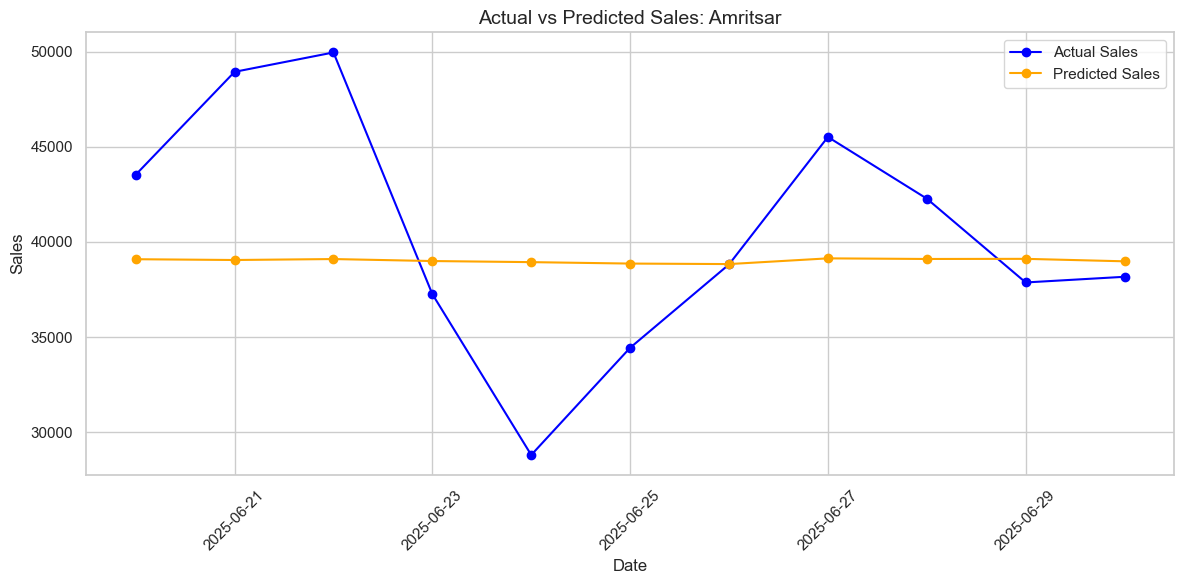

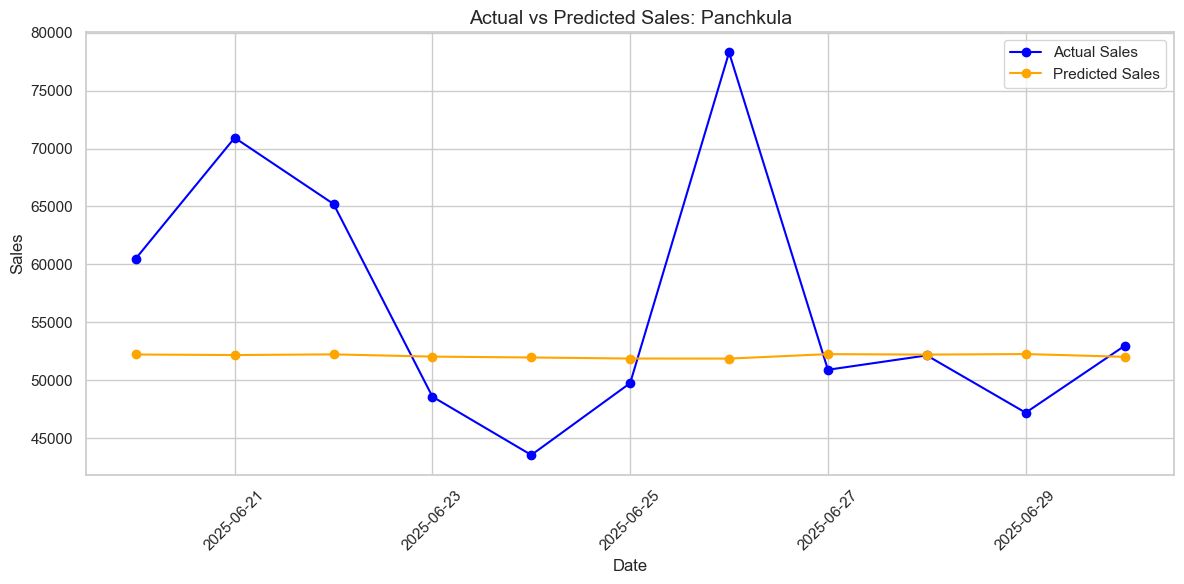

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set(style="whitegrid")

# Create a plot for each branch
branches = comparison_df['branch_name'].dropna().unique()

for branch in branches:
    branch_df = comparison_df[comparison_df['branch_name'] == branch]
    
    plt.figure(figsize=(12, 6))
    plt.plot(branch_df['order_date'], branch_df['actual_sales'], label='Actual Sales', marker='o', color='blue')
    plt.plot(branch_df['order_date'], branch_df['predicted_sales'], label='Predicted Sales', marker='o', color='orange')
    
    plt.title(f"Actual vs Predicted Sales: {branch}", fontsize=14)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Sales", fontsize=12)
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.grid(True)
    plt.show()
